In [1]:
import os
import re

import pickle

import numpy as np
from numpy import interp

import pandas as pd

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn


# preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler , Binarizer

# classification , crossvalidation
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, plot_roc_curve, auc

# feature creation
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# decomposition
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif, chi2, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
# csr utilites
import scipy
from scipy.sparse import csr_matrix

# stats
from scipy import stats
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import proportion_confint

from tqdm.notebook import tqdm

In [2]:
PATH_TO_DATA = 'capstone_user_identification'
N_GRAMMS = (1, 5)
sns.set()

In [3]:
import watermark
%load_ext watermark

In [4]:
%watermark --iversions
%watermark

seaborn   0.9.0
pandas    1.0.1
re        2.2.1
scipy     1.4.1
sklearn   0.22.1
numpy     1.18.1
watermark 2.0.2
json      2.0.9

2020-03-17T15:12:38+03:00

CPython 3.7.6
IPython 7.12.0

compiler   : GCC 7.3.0
system     : Linux
release    : 5.4.0-18-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


In [5]:
import main as m

# Отчет о выполненном проекте

## Цели и задачи проекта

Рассмотривается **задача идентификации взломщика по его поведению** в сети Интернет. Это сложная и интересная задача на стыке анализа данных и поведенческой психологии. В качестве примера, компания Яндекс решает задачу идентификации взломщика почтового ящика по его поведению.

В двух словах, взломщик будет себя вести не так, как владелец ящика: он может не удалять сообщения сразу по прочтении, как это делал хозяин, он будет по-другому ставить флажки сообщениям и даже по-своему двигать мышкой. Тогда такого злоумышленника можно идентифицировать и "выкинуть" из почтового ящика, предложив хозяину войти по SMS-коду. Этот пилотный проект описан в статье на Хабрахабре. Похожие вещи делаются, например, в Google Analytics и описываются в научных статьях, найти можно многое по фразам "Traversal Pattern Mining" и "Sequential Pattern Mining".

В этом **проекте решается** похожая задача: **алгоритм будет анализировать последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, и определять, Элис это или взломщик** (кто-то другой).

Данные собраны с прокси-серверов Университета Блеза Паскаля. ["A Tool for Classification of Sequential Data", авторы Giacomo Kahn, Yannick Loiseau и Olivier Raynaud](http://ceur-ws.org/Vol-1703/paper12.pdf).

## Описание исходных данных и признаков.

Исходные данные представлены в виде **последовательности логов посещения сайтов с временными отметками**.

Пример таблицы: (**timestamp**: время посещения сайта, **site**: название сайта); *id пользователя дано в названии файла.*

In [6]:
m.load_file()

,timestamp,site
0,2013-11-15 08:12:07,fpdownload2.macromedia.com
1,2013-11-15 08:12:17,laposte.net
2,2013-11-15 08:12:17,www.laposte.net
3,2013-11-15 08:12:17,www.google.com
4,2013-11-15 08:12:18,www.laposte.net


## Описание обработанных данных и признаков

Для классификации последовательнсти данных в [работе](http://ceur-ws.org/Vol-1703/paper12.pdf) вводится понятие **транзакции** - список из N сайтов посещенных последовательно. Число N может варьироваться. В текущей задаче в виде ограничений взяты следующие параметры 10 сайтов, 30 минут (чтобы в транзакции не присутствовали сайты, разграниченные большим промежутком времени).

Строится **таблица из списка сессий (транзакций)**. Названия сайтов заменяются индексами сайтов. 
Индексы получаются путем определения множества посещенных сайтов, сортировки сайтов по посещаемости и последующей нумерацией.

In [7]:
# колонки с временными данными
times_columns = ['time%d' % i for i in range(1, 11)]
# колонки с данными по сайтам
sites_columns = ['site%d' % i for i in range(1, 11)]

# загрузка тренировочных данныс с разметками
train_df, y = m.get_train_df(times_columns)
# загрузка данных для ответов, отсылаемых в kaggle
test_df = m.get_test_df(times_columns)
n = y.shape[0]  # количество транзакций в тренировочной выборке

**Таблица индексов сайтов**

In [8]:
# объединение обучаемой и тестовой выборок для синхронной обработки
train_test = m.prepare_data([train_df, test_df], times_columns, sites_columns)
train_test[sites_columns].head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


**Таблица времен посещения сайтов**

In [9]:
train_df[times_columns].head()

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
session_id,,,,,,,,,,
21669,2013-01-12 08:05:57,2013-01-12 08:05:57,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
54843,2013-01-12 08:37:23,2013-01-12 08:37:23,2013-01-12 09:07:07,2013-01-12 09:07:09,NaT,NaT,NaT,NaT,NaT,NaT
77292,2013-01-12 08:50:13,2013-01-12 08:50:14,2013-01-12 08:50:15,2013-01-12 08:50:15,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:17,2013-01-12 08:50:17
114021,2013-01-12 08:50:17,2013-01-12 08:50:17,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:19,2013-01-12 08:50:19,2013-01-12 08:50:19,2013-01-12 08:50:20
146670,2013-01-12 08:50:20,2013-01-12 08:50:20,2013-01-12 08:50:20,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:22,2013-01-12 08:50:22,2013-01-12 08:50:22


## Построение новых признаков

По исходным данным создаются следующие признаки:
    - длительность сессий;
    - количество уникальных сайтов в сессии:
    - временные параметры начала сессии (год, квартал, сезон(лето...), 
                                         месяц, день, день недели, время суток (день/ночь), час)

In [10]:
# количество уникальных сайтов
uniques = np.array(
    [len(set(row) - set([0])) for row in train_test[sites_columns].values])

# временные параметры начала сессии
mins = np.min(train_test[times_columns], axis=1)
maxs = np.max(train_test[times_columns], axis=1)
timespan = (maxs - mins).dt.seconds
# попытка приведения к нормальному распределению
timespan_log = np.log(timespan + 1)

# categorical
year = mins.dt.year
quarter = mins.dt.quarter
month = mins.dt.month
week = mins.dt.week
yyyymm = year * 100 + month
yyyyww = year * 100 + week

# categorical
hour = mins.dt.hour
dayofweek = mins.dt.dayofweek
weekday = mins.dt.weekday

# время суток
morning = ((hour >= 7) & (hour <= 11)).astype('uint8')
day = ((hour >= 12) & (hour <= 18)).astype('uint8')
evening = ((hour >= 19) & (hour <= 23)).astype('uint8')
night = ((hour >= 0) & (hour <= 6)).astype('uint8')

Ввод полученных данных в общую таблицу. 

In [11]:
# continous
train_test['timespan'] = timespan
train_test['timespan_log'] = timespan_log

# descrete
train_test['yyyymm'] = yyyymm.astype('uint32')
train_test['yyyyww'] = yyyyww.astype('uint32')
train_test['uniques'] = uniques.astype('uint8')

# categorical пока не вводятся так как они преобразуются в бинарные
train_test['dayofweek'] = dayofweek.astype('uint8')
train_test['month'] = month.astype('uint8')

# binary
train_test['morning'] = morning
train_test['day'] = day
train_test['evening'] = evening
train_test['night'] = night

In [12]:
# удаление временных отметок
train_test = train_test.drop(times_columns, axis=1)

## Первичный анализ признаков

Определим как устроены данные:

**Распределение целевого признака показывает, что выборка не сбалансирована (~ 1%). Дисбаланс классов очень сильный и смотреть на долю верных ответов (accuracy) непоказательно.**

In [13]:
y.value_counts()

0    251264
1      2297
Name: target, dtype: int64

**Временные рамки датасетов не пересекаются:**

In [14]:
m.train_test_distribution(mins, y.shape[0])

train : [ 2013-01-12 08:05:57 ; 2014-04-30 23:39:53 ]
test : [ 2014-05-01 17:14:03 ; 2014-12-05 23:26:53 ]


Проверим **гипотезу о том, что пользователь хотя бы раз зайдет на сайт, который он уже ранее посетил в сессии из 10 сайтов**.
Проверяется с помощью биномиального критерия для доли, что доля случаев, когда пользователь повторно посетил какой-то сайт (то есть число уникальных сайтов в сессии < 10) велика: больше 95%. Альтернатива тому, что доля равна 95% – одностороняя

In [15]:
has_two_similar = (np.array(uniques) < 10).astype('int')
p_val = stats.binom_test(sum(has_two_similar),
                         len(has_two_similar),
                         p=0.95,
                         alternative="greater")
print(f'p-value = {p_val}')

p-value = 4.452441534873283e-140


**Нулевая гипотеза о том, что вероятность равна 95%, отвергается в пользу альтернативы (альтернатива = вероятность больше, чем 0,95).**

Рассчитаем 95% доверительный **интервал Уилсона для доли случаев, когда пользователь повторно посетил какой-то сайт**.

In [16]:
wilson_interval = proportion_confint(sum(has_two_similar),
                                     len(has_two_similar),
                                     method='wilson')
print('Wilson int.: [{} ; {}]'.format(round(wilson_interval[0], 3),
                                      round(wilson_interval[1], 3)))

Wilson int.: [0.958 ; 0.96]


Отвечая на подобные вопросы, можно понять, дает ли данный набор данных основания полагать, что за пользователями наблюдается какое-то характерное им поведение.

## Первичный визуальный анализ признаков

Визуальный анализ дает качественный анализ на состоятельность тех или иных признаков, нахождение новых закономерностей.

### **Распределение объектов обучающей и тестовой выборок по времени (yyyyww):**

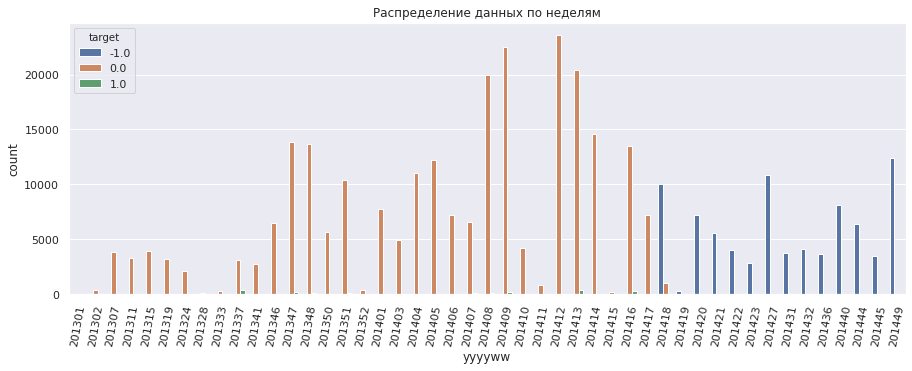

In [17]:
# данные теста
train_test['target'] = train_test['target'].fillna(-1)

plt.figure(figsize=(15, 5))
weeks = sorted(set(yyyyww))
sns.countplot(x='yyyyww', data=train_test, hue='target')
plt.xticks(range(len(weeks)), weeks, rotation=80)
plt.title("Распределение данных по неделям")
plt.show()

Замечаем, что в 2013 году мало данных.

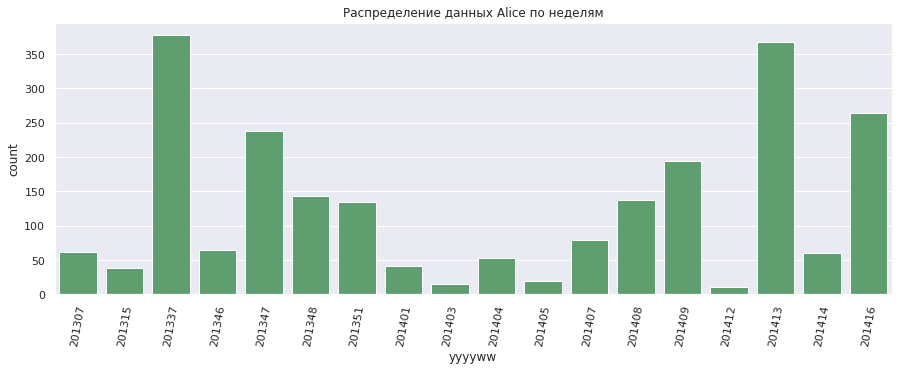

In [18]:
plt.figure(figsize=(15, 5))
X = train_test[train_test.target == 1]
weeks = sorted(set(X['yyyyww']))
sns.countplot(x="yyyyww", data=X, color='g')
plt.xticks(range(len(weeks)), weeks, rotation=80)
plt.title("Распределение данных Alice по неделям")
plt.show()

Первые 36 недель 2013 года содержат мало данных Элис.

### **Распределение объектов обучающей и тестовой выборок по времени (yyyymm):**

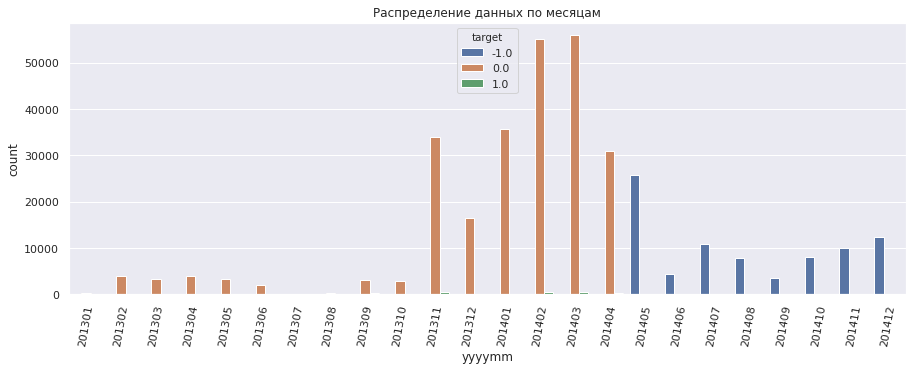

In [19]:
plt.figure(figsize=(15, 5))
ms = sorted(set(yyyymm))
sns.countplot(x='yyyymm', data=train_test, hue='target')
plt.xticks(range(len(ms)), ms, rotation=80)
plt.title("Распределение данных по месяцам")
plt.show()

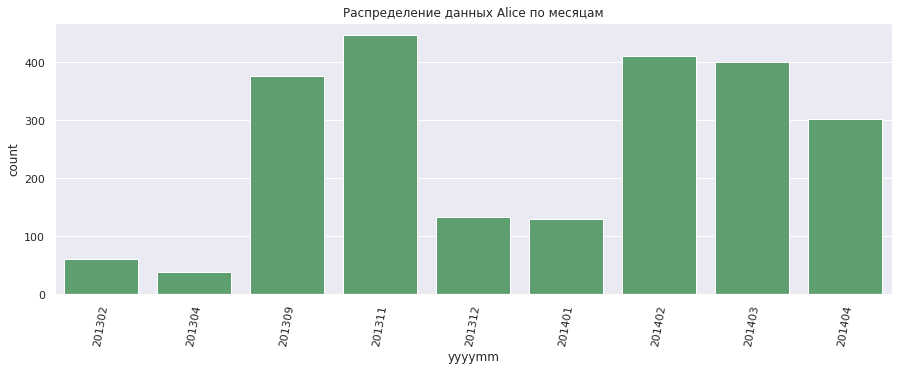

In [20]:
plt.figure(figsize=(15, 5))
X = train_test[train_test.target == 1]
ms = sorted(set(X['yyyymm']))
sns.countplot(x="yyyymm", data=X, color='g')
plt.xticks(range(len(ms)), ms, rotation=80)
plt.title("Распределение данных Alice по месяцам")
plt.show()

### **Распределение данных по дням недели.**

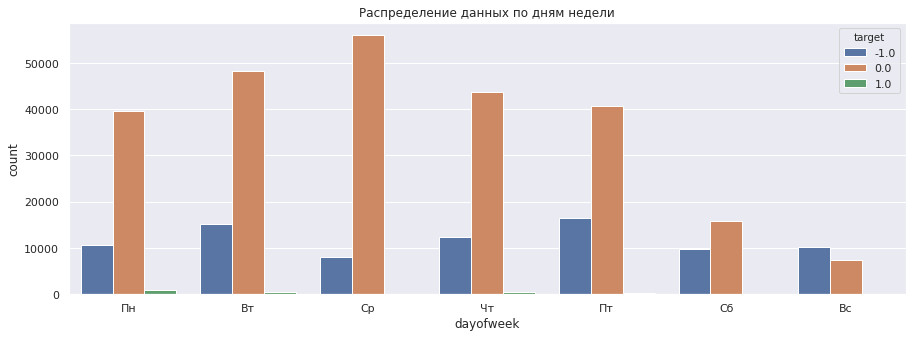

In [21]:
plt.figure(figsize=(15, 5))
X = train_test
weeks = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
sns.countplot(x="dayofweek", data=X, hue='target')
plt.xticks(range(len(weeks)), weeks, rotation=0)
plt.title("Распределение данных по дням недели")
plt.show()

Отдельныйй график для Элис.

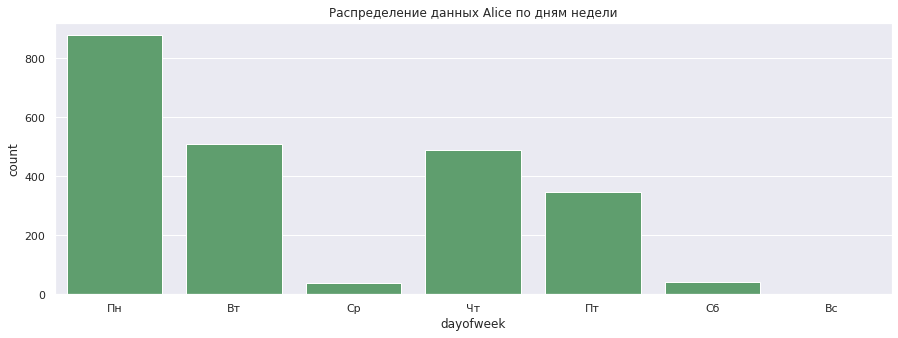

In [22]:
plt.figure(figsize=(15, 5))
X = train_test[train_test.target == 1]
weeks = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] 
sns.countplot(x="dayofweek", data=X, color = 'g')
plt.xticks(range(len(weeks)), weeks, rotation=0)
plt.title("Распределение данных Alice по дням недели")
plt.show()

Элис работает в интернете в основном по Пн., Вт., Чт., Пт..

Но также можно проверить различие распределений выборок с помощью критерия Манна-Уитни.

$$X^{n_1}_1=(X_{11},...,X_{1{n_1}}) ,  \\ X^{n_2}_2=(X_{21},...,X_{2{n_2}}); \\ H_0: F_{x_1}(X)=F_{X_2}(X); \\ H_1: F_{x_1}(X)=F_{X_2}(X+\Delta), \Delta< \neq >0; \\ R_1(X^{n_1}_1, X^{n_2}_2)=\sum^{n_1}_{i=1}rank(X_{1i}) ; \\ W(X^n_1, X^n_2) \sim табличное. $$

In [23]:
# Compute the Mann-Whitney rank test on samples x and y.
a = train_test[train_test[:n].target == 1]["dayofweek"]
b = train_test[train_test[:n].target == 0]["dayofweek"]
mannwhitneyu(a, b, alternative="two-sided")

MannwhitneyuResult(statistic=413608802.5, pvalue=3.100318507922654e-73)

Критерий Манна-Уитни отвергает нулевую гипотезу о равенстве распределений в пользу альтернативы.

### **Количество уникальных сайтов в сессии**

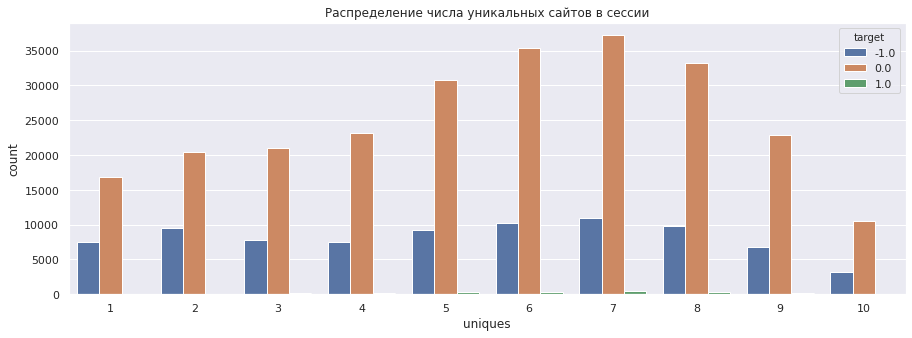

In [24]:
plt.figure(figsize=(15, 5))
X = train_test
# X['unique'] = uniques
sns.countplot(x="uniques", data=X, hue='target')
plt.title("Распределение числа уникальных сайтов в сессии")
plt.show()

Количество уникальных сайтов для Элис.

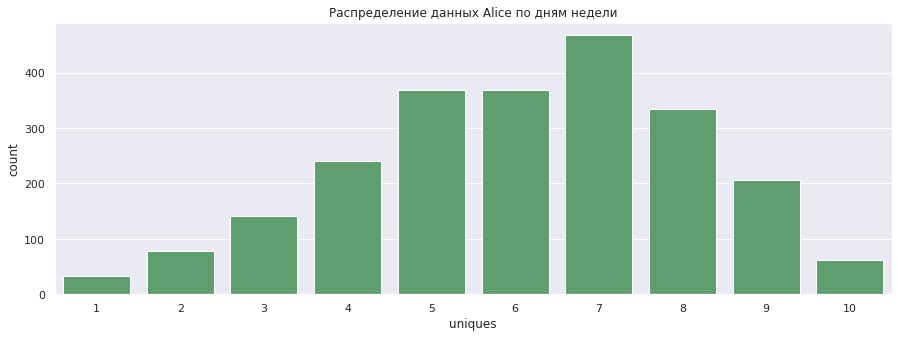

In [25]:
plt.figure(figsize=(15, 5))
X = train_test[train_test.target == 1]
sns.countplot(x="uniques", data=X,color = 'g')
plt.title("Распределение данных Alice по дням недели")
plt.show()

Здесь уже не так визуально очевидна разница между распределениями. Что покажет критерий Манна-Уитни?

In [26]:
a = train_test[train_test[:n].target == 1]["uniques"]
b = train_test[train_test[:n].target == 0]["uniques"]
mannwhitneyu(a, b, alternative="two-sided")

MannwhitneyuResult(statistic=548494906.0, pvalue=9.340921715854851e-14)

Критерий выбирает альтернативную гипотезу (о неравенстве распределений).

### **Распределение timespan**

Рассмотрим как распределены численные признаки.

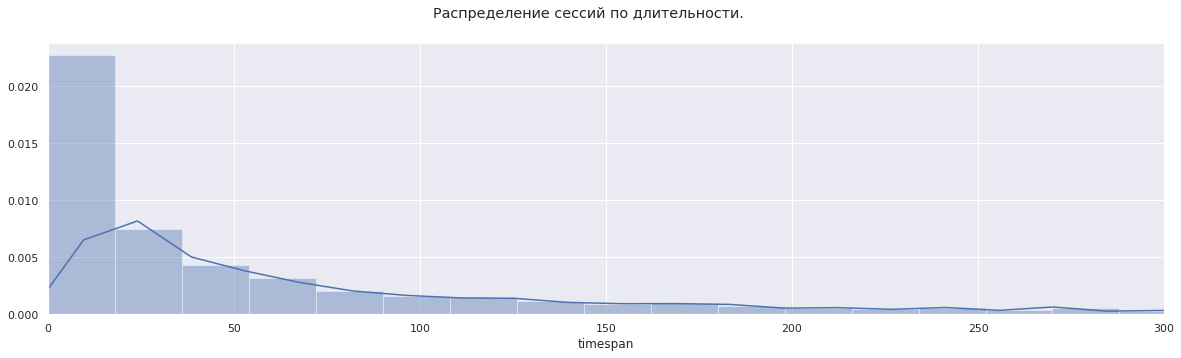

In [27]:
plt.figure(figsize=(20, 5))
sns.distplot(train_test['timespan'], bins=100)
plt.suptitle("Распределение сессий по длительности.")
plt.xlim([0,300])
plt.show()

Данное распределение 'плохое', стоит его преобразовать более близкому к гауссовскому.

Логарифмирование

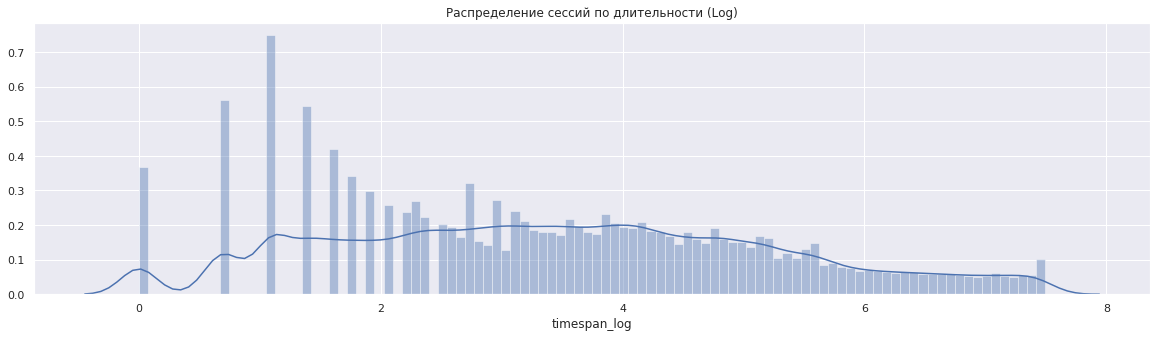

In [28]:
plt.figure(figsize=(20, 5))
sns.distplot(train_test['timespan_log'], bins=100)
plt.title("Распределение сессий по длительности (Log)")
plt.show()

Box-Cox

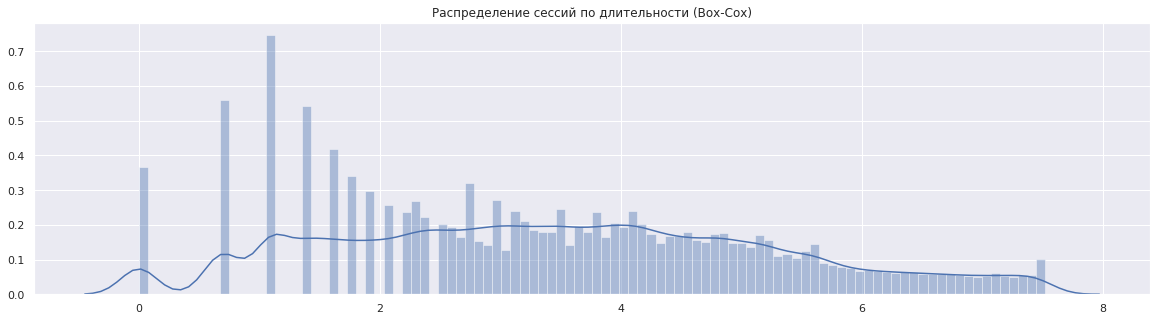

In [29]:
timespan_boxcox = stats.boxcox((timespan + 1), lmbda = 0.001)
plt.figure(figsize=(20, 5))
sns.distplot(timespan_boxcox, bins=100)
plt.title("Распределение сессий по длительности (Box-Cox)")
plt.show()

Yeojohnson

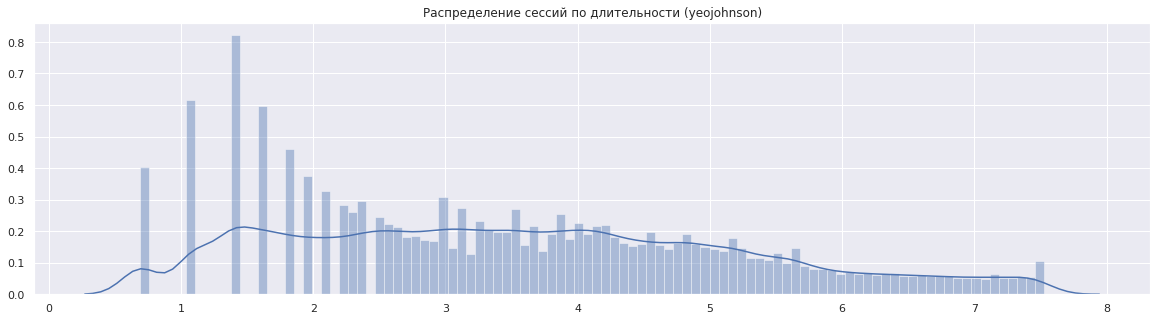

In [30]:
yeojohnson = stats.yeojohnson((timespan + 1), lmbda = 0.001)
plt.figure(figsize=(20, 5))
sns.distplot(yeojohnson, bins=100)
plt.title("Распределение сессий по длительности (yeojohnson)")
plt.show()

Дополнительные преобразования не сильно отличаются от простого логарифмирования. 

Много сайтов с длительностями посещений близкими к нулю. 

Замена нулевых значений средними не дает результата.

Распределение длительности сессий для Элис.

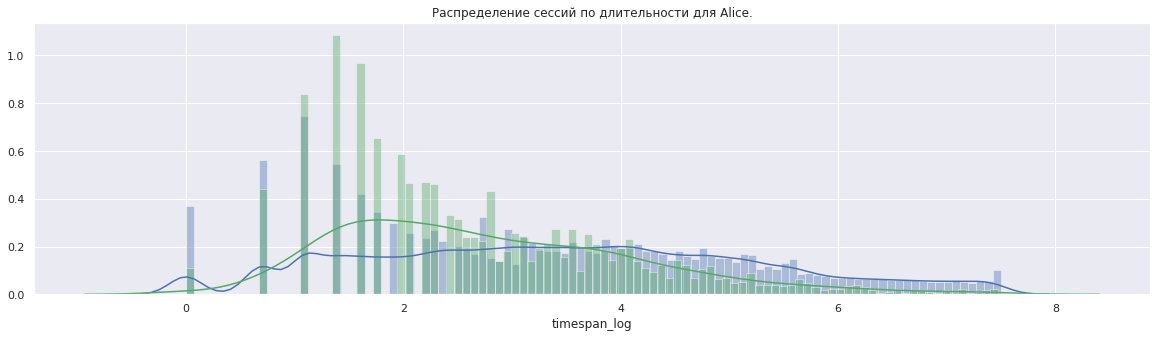

In [31]:
plt.figure(figsize=(20, 5))
sns.distplot(train_test['timespan_log'], bins=100)
sns.distplot(np.log(train_test[train_test['target']==1]['timespan']+1), bins=100, color = 'g')
plt.title("Распределение сессий по длительности для Alice.")
plt.xlabel('timespan_log')
plt.show()

## Описание предобработки данных

### Scaler

Вещественные признаки, которые имеют большой разброс следует промасштабировать. В данном случае признаки центрируются по среднему и масштабируются по отклонению.

In [32]:
columns_to_scale = ['uniques', 'month', 'dayofweek']
train_test[columns_to_scale].head()

,uniques,month,dayofweek
session_id,,,
21669,2,1,5
54843,2,1,5
77292,6,1,5
114021,5,1,5
146670,6,1,5


Обучаем scaler на бучаемой выборке, затем применяем масштабирование к тестовой.

In [33]:
scaler = StandardScaler().fit(train_test[columns_to_scale][:n])
train_test[columns_to_scale] = scaler.transform(train_test[columns_to_scale])
train_test[columns_to_scale].head()

,uniques,month,dayofweek
session_id,,,
21669,-1.457582,-0.943567,1.682905
54843,-1.457582,-0.943567,1.682905
77292,0.144865,-0.943567,1.682905
114021,-0.255747,-0.943567,1.682905
146670,0.144865,-0.943567,1.682905


### One hot Encoding

Категориальные признаки приводятся к бинарным (one-hot).

In [34]:
uniques_noscale = uniques
month_noscale = month
dayofweek_noscale = dayofweek

In [35]:
year = pd.get_dummies(year, prefix='year',dtype ='uint8')
quarter = pd.get_dummies(quarter, prefix='quarter',dtype ='uint8')
month = pd.get_dummies(month, prefix='month',dtype ='uint8')
week = pd.get_dummies(week, prefix='week',dtype ='uint8')
dayofweek = pd.get_dummies(dayofweek, prefix='dayofweek',dtype ='uint8')
hour = pd.get_dummies(hour, prefix='hour',dtype ='uint8')
uniques = pd.get_dummies(uniques, prefix='uniques',dtype ='uint8')

In [36]:
uniques.head()

,uniques_1,uniques_2,uniques_3,uniques_4,uniques_5,uniques_6,uniques_7,uniques_8,uniques_9,uniques_10
0,0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0


In [37]:
del test_df, train_df
del has_two_similar, maxs, mins, timespan_boxcox, yeojohnson

##  Кросс-валидация

В качестве кроссвалидации воспользуемся временной кроссвалидацией TimeSeriesSplit. Тренировки проходят на данных за прошлое время, тесты проходят на новых данных.
Рассмотрим, как выбранная кроссвалидация разделяет данные по неделям.

<img src = 'sphx_glr_plot_cv_indices_0101.png'>Time Split</img>

Тестировние происходит с 41 недели 2013 года.

In [38]:
X = yyyyww[:n].values
tscv = TimeSeriesSplit(n_splits=10)
print(tscv)
for train, test in tscv.split(X):
    print(f'Train: {X[train[[0, -1]]]} Test: {X[test[[0, -1]]]}')

TimeSeriesSplit(max_train_size=None, n_splits=10)
Train: [201302 201341] Test: [201341 201348]
Train: [201302 201348] Test: [201348 201351]
Train: [201302 201351] Test: [201351 201404]
Train: [201302 201404] Test: [201404 201406]
Train: [201302 201406] Test: [201406 201408]
Train: [201302 201408] Test: [201408 201409]
Train: [201302 201409] Test: [201409 201412]
Train: [201302 201412] Test: [201412 201413]
Train: [201302 201413] Test: [201413 201414]
Train: [201302 201414] Test: [201414 201418]


Вспомним, что в начале мало данных. Поэтому нам интересны предсказания лишь со 2ой половины тренировочной выборки (по последним 5 фолдам).

### Новая кросс-валидация (5 последних фолдов из 10)

In [39]:
# class with interface of Cross-Validation Split
class AliceSplit(TimeSeriesSplit):
    def __init__(self, n_splits=10, last_splits=6):
        super().__init__(n_splits, max_train_size=None)
        self.cv = TimeSeriesSplit(n_splits)
        self.n_splits = last_splits
        self.last_splits = last_splits

    def split(self, X, y=None, groups=None):
        return list(self.cv.split(X, y=None, groups=None))[-self.n_splits:]

In [40]:
alice_cv = AliceSplit(n_splits=10, last_splits=5)
print(alice_cv)

AliceSplit(last_splits=5, n_splits=5)


In [41]:
X = yyyyww[:n].values
for train, test in alice_cv.split(X):
    print(f'Train: {X[train[[0, -1]]]} Test: {X[test[[0, -1]]]}')

Train: [201302 201408] Test: [201408 201409]
Train: [201302 201409] Test: [201409 201412]
Train: [201302 201412] Test: [201412 201413]
Train: [201302 201413] Test: [201413 201414]
Train: [201302 201414] Test: [201414 201418]


## Модель BagOfWords

### Bag of Sites

К таблице списка сессий применяется стандартная модель NLP "мешок слов". В данной модели не важен порядок сайтов в сессии.

Чтобы как-то учесть порядок слов вводятся N-граммы. N сайтов, которые встречаются вместе. [wiki](https://en.wikipedia.org/wiki/Bag-of-words_model)

In [42]:
def get_sparse(X, y, nr=(1, 1), tp='\w+', max_features=None):
    """Returns table of word-vectors as sparse matrix"""

    vectorizer = CountVectorizer(ngram_range=nr,
                                 token_pattern=tp,
                                 max_features=max_features)
    n = y.shape[0]
    X_docs = [" ".join(map(str, row)) for row in X]
    # Determine vocabulary_ of Counting ngrams
    vectorizer.fit(X_docs[:n])
    # Transform X to table of counts
    X_transformed = vectorizer.transform(X_docs)

    return X_transformed, vectorizer.vocabulary_

При подсчитывании n-gramm (словосочетаний), сохранились комбинации с пропусками(0).

Вожможно, дополнительное знание и 'пустых' сессиях поможет улучшить качество классификатора.

### TF-IDF

Так же рассмотрим трансформацию [tf-idf](https://ru.wikipedia.org/wiki/TF-IDF) над мешком слов.

*Вес некоторого слова пропорционален частоте употребления этого слова в документе и обратно пропорционален частоте употребления слова во всех документах коллекции.*

In [43]:
def get_tfidf(X, y):
    n = y.values.shape[0]
    tfidf = TfidfTransformer(norm='l2', sublinear_tf=True, use_idf=True)
    tfidf.fit(X[:n])
    return tfidf.transform(X)

### Сохранение модели.

save objects

load objects

In [44]:
def get_o(name):
    with open(os.path.join(PATH_TO_DATA, name + '.pkl'), 'rb') as file:
        o = pickle.load(file)
    return o


def save_o(obj, name):
    with open(os.path.join(PATH_TO_DATA, name + '.pkl'), 'wb') as file:
        pickle.dump(obj, file, protocol=2)


[BoS, TF, y] = [get_o(name) for name in ['BoS', 'TF', 'y']]
n = y.shape[0]

### MaxAbsScaler

Масштабирование по MaxAbs

In [45]:
scaler = MaxAbsScaler()

In [46]:
scaler.fit(BoS[:n], y)
BoS_scaled = scaler.transform(BoS)

scaler.fit(TF[:n], y)
TF_scaled = scaler.transform(TF)

### Binarization

Бинаризация

In [47]:
binarizer = Binarizer()
binarizer.fit(BoS[:n], y)
BoS_bin = binarizer.transform(BoS)

TF_bin = get_tfidf(BoS_bin, y)

In [48]:
scaler.fit(TF_bin[:n], y)
TF_bin_scaled = scaler.transform(TF_bin)

## Линейный классификатор SGD_logit

В качестве классификатора используется [логистическая регрессия](http://www.machinelearning.ru/wiki/index.php?title=%D0%9B%D0%BE%D0%B3%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F). 

Делается предположение о том, что вероятность наступления события ${\displaystyle y=1}$ равна:
$P(y=1|x) = f(z)$. 

Где $z = \theta_0+\theta_1 x_1+...$ . $x$ - признаки, $\theta$ - коэффициенты регреcсии, $f(z)=\frac{1}{1+e^{-z}}$ - логистическая функция (сигмоид, логит-функция) преобразует значения регрессии на область (0;1).

Получившийся линейный классификатор является оптимальным байесовским классификатором.

Трактовать выходы сигмоидных функций как вероятности следует с большой осторожностью. На самом деле они дают лишь оценку удалённости объекта от границы классов, нормированную так, чтобы она принимала значения из отрезка [0,1].

В качестве оптимизатора потерь (верхней оценки эмпирического риска) используется Стахостический Градиентный Спуск (Stochastic Gradient Descent). SGD на много быстрее решает задачу, чем стандартные оптимизаторы для логистической регрессии.

В качестве защиты от переобучения используется l2 регуляризация.

### Обучение классификатора

Обучение происходит путем подбора параметра alpha, на котором классификатор выдает максимальное среднее значение auc_roc score на кроссвалидации.

##### Function of optimization

In [49]:
def search_alpha(
        X,
        y,
        parameters,
        clf_base,
        n_jobs=-1,
        cv=alice_cv,
):
    """
    Searches best parameter for SGDClassifier on cv.
    Returns best scores on cv, best_estimator, X, cv_results
    """
    n = y.shape[0]

    # search alpha
    clf = GridSearchCV(clf_base,
                       param_grid=parameters,
                       scoring='roc_auc',
                       verbose=1,
                       n_jobs=n_jobs,
                       cv=cv,
                       return_train_score=False,
                       refit=True)
    clf.fit(X[:n], y)
    print(clf.best_params_, clf.best_score_)

    # plotting auc_score by alpha
    for k in parameters.keys():
        plot_alpha_scores(parameters[k], clf.cv_results_)

    # find scores on best alpha and plotting cross-validation roc-auc
    scores = check_alpha(clf.best_estimator_, X[:n], y.values, cv)

    # print scores
    scores_info("Scores", scores[0])

    cv_scores = np.array(scores[0])
    fpr, tpr = scores[-2:]

    return cv_scores, fpr, tpr, clf.best_estimator_, clf.best_params_, clf.cv_results_


def plot_alpha_scores(alpha_range, cv_results):
    """
    Plot cv-scores by alpha
    """
    plt.figure(figsize=(18, 5))
    sns.lineplot(x=alpha_range, y=cv_results['mean_test_score'], label='Mean')
    sns.lineplot(x=alpha_range,
                 y=cv_results['mean_test_score'] -
                 cv_results['std_test_score'],
                 color='red',
                 label='Min')
    plt.xticks(rotation=45)
    plt.xlabel('alpha')
    plt.ylabel('ROC_AUC score')
    plt.title('Оптимизация alpha')
    legend = plt.legend(loc='lower center')
    plt.show()


def check_alpha(opt_clf, X, y, cv=TimeSeriesSplit(10)):
    """
    Returnes scores from cv for given classification.
    Plots ROC curves for cv-scores.
    """
    scores = []
    n = y.shape[0]
    T = X[:n]

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(15, 5))
    for i, (train, test) in enumerate(cv.split(T, y)):
        opt_clf.fit(T[train], y[train])
        viz = plot_roc_curve(opt_clf,
                             T[test],
                             y[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.5,
                             lw=1,
                             ax=ax)
        interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        scores.append(
            roc_auc_score(y[test],
                          opt_clf.predict_proba(T[test])[:, 1]))

    ax.plot([0, 1], [0, 1],
            linestyle='--',
            lw=2,
            color='r',
            label='Chance',
            alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr,
            mean_tpr,
            color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2,
            alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr,
                    tprs_lower,
                    tprs_upper,
                    color='grey',
                    alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05],
           ylim=[-0.05, 1.05],
           title="Receiver operating characteristic")
    ax.legend(loc="lower right")

    plt.show()

    return scores, mean_fpr, mean_tpr


def scores_info(text, scores: np.array):
    """
    Prints scores info.
    """
    print(
        f'{text:15s}: {np.mean(scores):.4f} (+/-{np.std(scores):.4f}) {list(map(lambda x: round(x, 4), scores))}'
    )


def model_assessment(model, X, Y, cv, n_jobs):
    """
    Returns scores from cross-validation.
    """
    cv_scores = cross_val_score(model,
                                X,
                                Y,
                                cv=cv,
                                scoring='roc_auc',
                                n_jobs=n_jobs,
                                verbose=1)
    scores_info("ROC_AUC score: ", cv_scores)
    return cv_scores

### Counter

In [50]:
daytime = ['morning', 'day', 'evening']

In [51]:
F = train_test[daytime+ ['dayofweek', 'month']]
F.head()

,morning,day,evening,dayofweek,month
session_id,,,,,
21669,1,0,0,1.682905,-0.943567
54843,1,0,0,1.682905,-0.943567
77292,1,0,0,1.682905,-0.943567
114021,1,0,0,1.682905,-0.943567
146670,1,0,0,1.682905,-0.943567


Проведем обучение на полной таблице сессий с 3 млн признаков.

In [72]:
BoS, F.shape

(<336358x2975923 sparse matrix of type '<class 'numpy.int64'>'
 	with 9677956 stored elements in Compressed Sparse Row format>,
 (336358, 5))

Fitting 5 folds for each of 151 candidates, totalling 755 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 755 out of 755 | elapsed: 15.5min finished


{'alpha': 6.025595860743581e-06} 0.9509144102534901


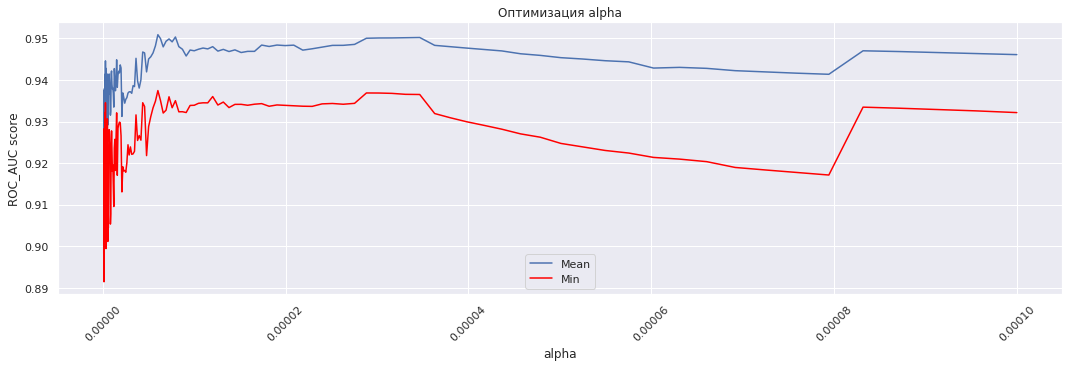

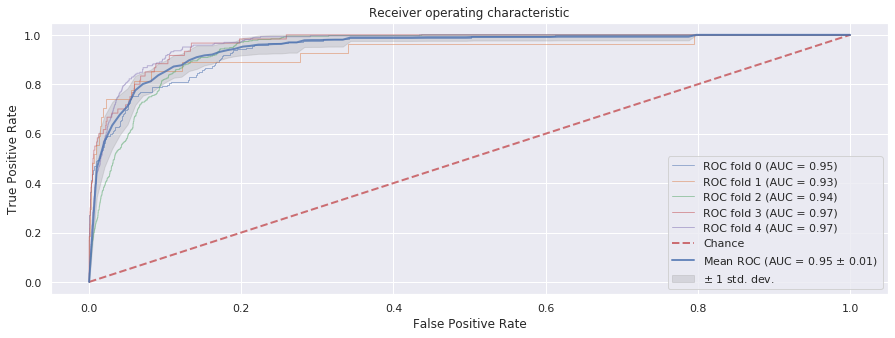

Scores         : 0.9509 (+/-0.0135) [0.946, 0.9316, 0.9446, 0.9663, 0.9661]
CPU times: user 23.9 s, sys: 3.07 s, total: 27 s
Wall time: 15min 43s


In [73]:
%%time

# search alpha throught cross validation
Z = BoS
X = csr_matrix(scipy.sparse.hstack([Z, F.values]))

search_range = np.logspace(-7, -4, 151)
parameters = dict([('alpha', search_range)])
clf = SGDClassifier(random_state=17, n_jobs=-1, loss='log')

result_BoS = search_alpha(X[:n], y, parameters, clf_base=clf, cv=alice_cv)

### **Counter -> TF-IDF**

In [134]:
TF

<336358x2975923 sparse matrix of type '<class 'numpy.float64'>'
	with 9677956 stored elements in Compressed Sparse Row format>

Fitting 5 folds for each of 151 candidates, totalling 755 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 755 out of 755 | elapsed:  7.0min finished


{'alpha': 3.4673685045253164e-07} 0.9607289020981515


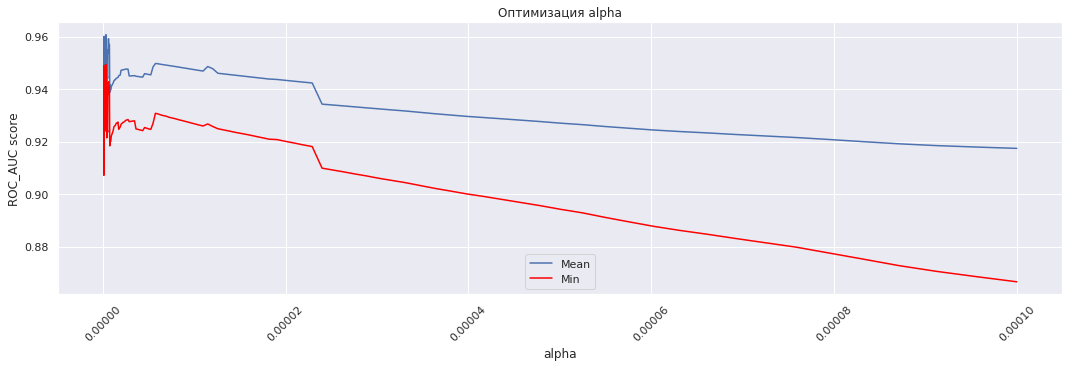

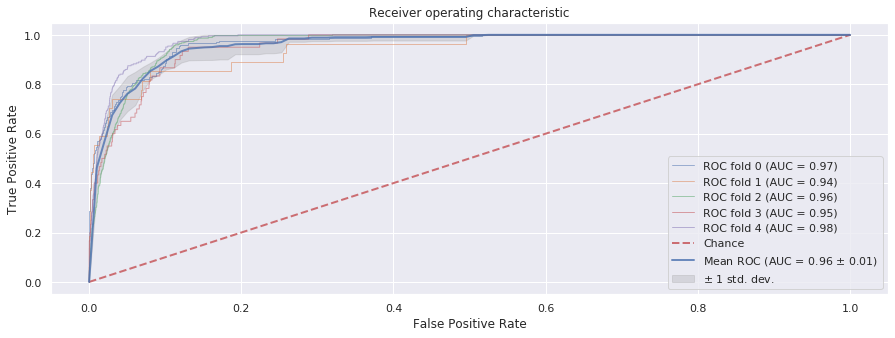

Scores         : 0.9607 (+/-0.0114) [0.9655, 0.9424, 0.9649, 0.9547, 0.9761]
CPU times: user 24.4 s, sys: 3.44 s, total: 27.9 s
Wall time: 7min 14s


In [74]:
%%time
Z = TF

X = csr_matrix(scipy.sparse.hstack([Z, F.values]))

search_range = np.logspace(-7, -4, 151)
parameters = dict([('alpha', search_range)])
clf = SGDClassifier(random_state=17, n_jobs=-1, loss='log')

result_TF = search_alpha(X[:n], y, parameters, clf_base=clf, cv=alice_cv)

In [136]:
# {'alpha': 4.800000000000001e-07} 0.9031549978705004
# 0.9032 (+/-0.0229) [0.8841, 0.9069, 0.8707, 0.9324, 0.9217]

### Counter -> Scaled

In [137]:
BoS_scaled

<336358x2975923 sparse matrix of type '<class 'numpy.float64'>'
	with 9677956 stored elements in Compressed Sparse Row format>

Fitting 5 folds for each of 151 candidates, totalling 755 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 755 out of 755 | elapsed:  7.0min finished


{'alpha': 4.570881896148752e-06} 0.9542546034700431


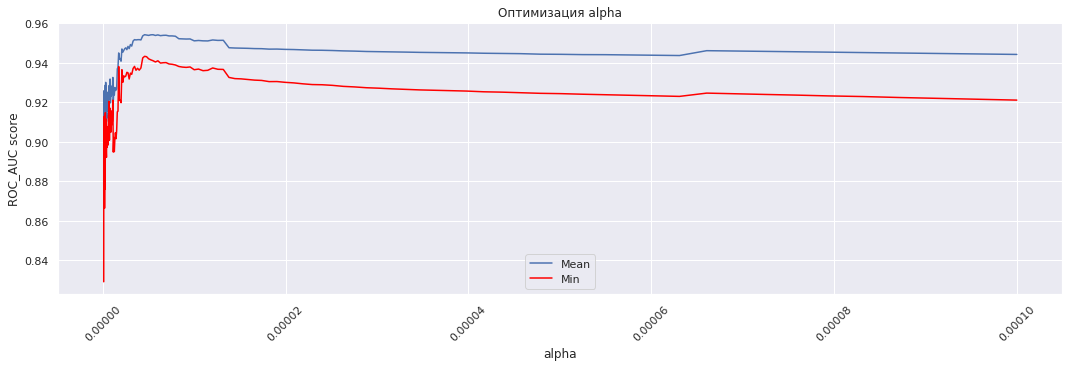

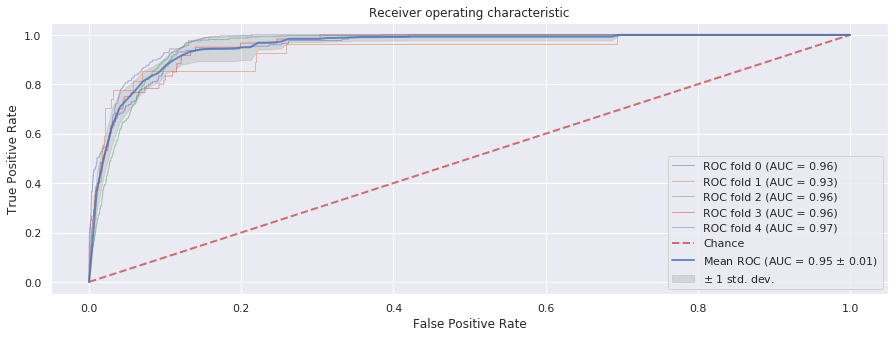

Scores         : 0.9543 (+/-0.0110) [0.9556, 0.9345, 0.9569, 0.9558, 0.9684]
CPU times: user 20.3 s, sys: 3.31 s, total: 23.6 s
Wall time: 7min 8s


In [75]:
%%time

Z = BoS_scaled
X = csr_matrix(scipy.sparse.hstack([Z, F.values]))
search_range = np.logspace(-7, -4, 151)

parameters = dict([('alpha', search_range)])
clf = SGDClassifier(random_state=17, n_jobs=-1, loss='log', penalty='l2')

result_BoS_scaled = search_alpha(X[:n],
                                 y,
                                 parameters,
                                 clf_base=clf,
                                 cv=alice_cv)

### **Counter -> TF-IDF -> Scaled**

In [139]:
TF_scaled

<336358x2975923 sparse matrix of type '<class 'numpy.float64'>'
	with 9677956 stored elements in Compressed Sparse Row format>

Fitting 5 folds for each of 151 candidates, totalling 755 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   44.1s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  2.8min
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:  5.0min
[Parallel(n_jobs=7)]: Done 755 out of 755 | elapsed:  7.0min finished


{'alpha': 5.4954087385762485e-06} 0.9576292352965934


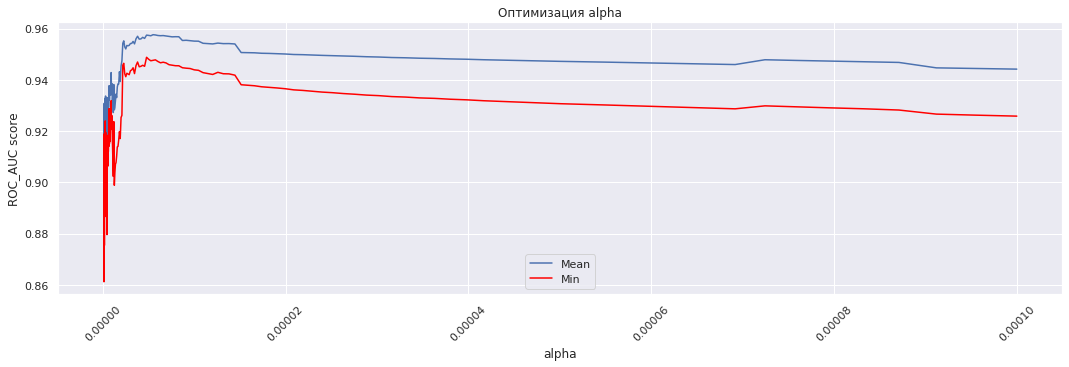

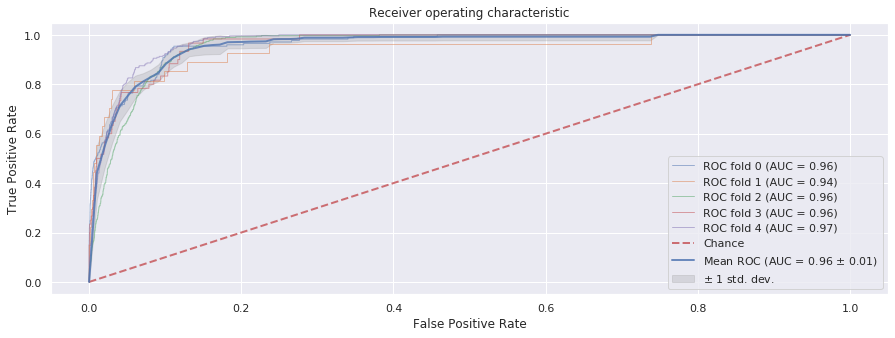

Scores         : 0.9576 (+/-0.0100) [0.9616, 0.9396, 0.9555, 0.9622, 0.9692]
CPU times: user 20.3 s, sys: 3.51 s, total: 23.8 s
Wall time: 7min 6s


In [76]:
%%time

Z = TF_scaled
X = csr_matrix(scipy.sparse.hstack([Z, F.values]))
search_range = np.logspace(-7, -4, 151)

parameters = dict([('alpha', search_range)])
clf = SGDClassifier(random_state=17, n_jobs=-1, loss='log', penalty='l2')

result_TF_scaled = search_alpha(X[:n],
                                y,
                                parameters,
                                clf_base=clf,
                                cv=alice_cv,
                                n_jobs=7)

### **Counter Binarized**

In [141]:
BoS_bin

<336358x2975923 sparse matrix of type '<class 'numpy.int64'>'
	with 9677956 stored elements in Compressed Sparse Row format>

Fitting 5 folds for each of 151 candidates, totalling 755 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 755 out of 755 | elapsed:  8.2min finished


{'alpha': 1.2589254117941661e-05} 0.9564847682643156


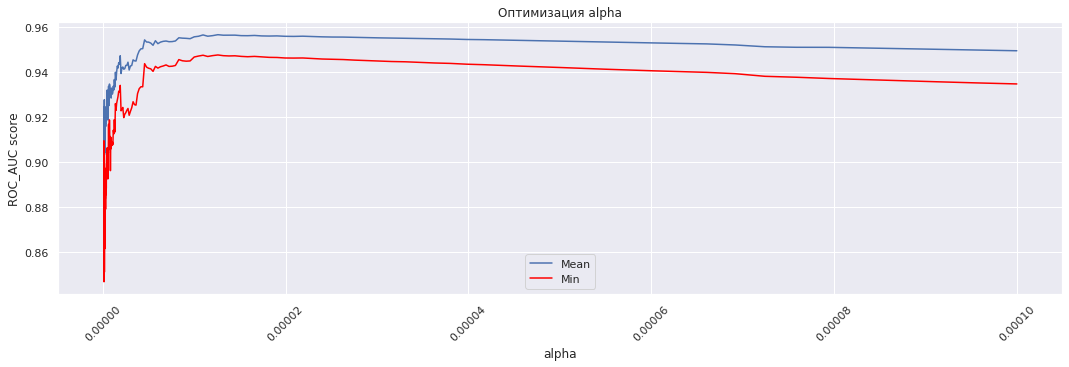

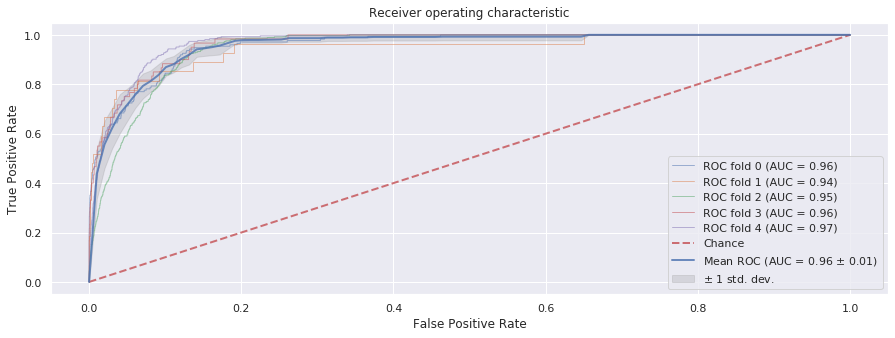

Scores         : 0.9565 (+/-0.0090) [0.9572, 0.9447, 0.9481, 0.9644, 0.968]
CPU times: user 19.9 s, sys: 3.23 s, total: 23.1 s
Wall time: 8min 21s


In [77]:
%%time

Z = BoS_bin
X = csr_matrix(scipy.sparse.hstack([Z, F.values]))
search_range = np.logspace(-7, -4, 151)

parameters = dict([('alpha', search_range)])
clf = SGDClassifier(random_state=17, n_jobs=-1, loss='log', penalty='l2')

result_BoS_bin = search_alpha(X[:n], y, parameters, clf_base=clf, cv=alice_cv)

### Counter Binarized -> TF-IDF

In [143]:
TF_bin

<336358x2975923 sparse matrix of type '<class 'numpy.float64'>'
	with 9677956 stored elements in Compressed Sparse Row format>

Fitting 5 folds for each of 151 candidates, totalling 755 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 755 out of 755 | elapsed:  6.7min finished


{'alpha': 1.2589254117941662e-07} 0.9606219185106782


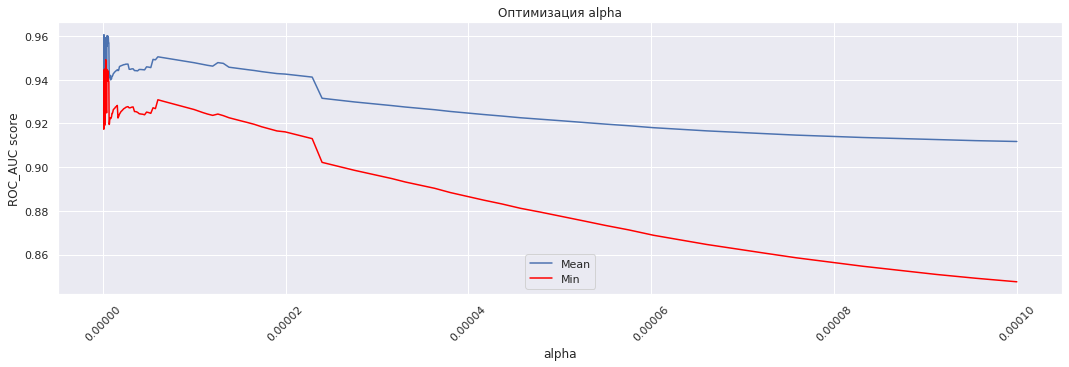

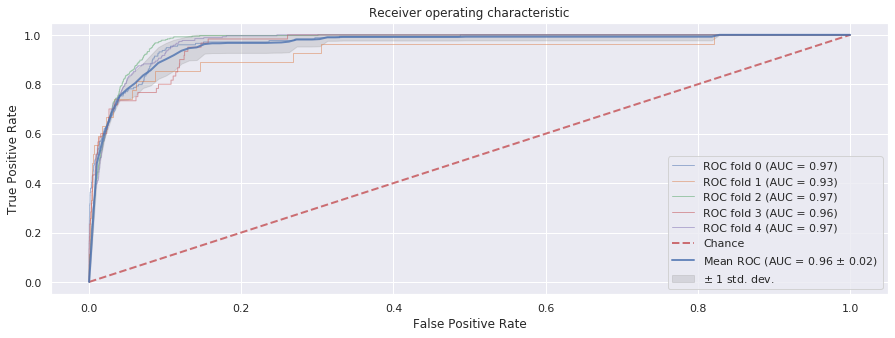

Scores         : 0.9606 (+/-0.0161) [0.9663, 0.9297, 0.9747, 0.9616, 0.9708]
CPU times: user 27 s, sys: 3.76 s, total: 30.7 s
Wall time: 6min 58s


In [78]:
%%time

Z = TF_bin
X = csr_matrix(scipy.sparse.hstack([Z, F.values]))
search_range = np.logspace(-7, -4, 151)

parameters = dict([('alpha', search_range)])
clf = SGDClassifier(random_state=17, n_jobs=-1, loss='log', penalty='l2')

result_TF_bin = search_alpha(X[:n], y, parameters, clf_base=clf, cv=alice_cv)

### **Counter Binarized -> TF-IDF -> Scaled**

In [145]:
TF_bin_scaled

<336358x2975923 sparse matrix of type '<class 'numpy.float64'>'
	with 9677956 stored elements in Compressed Sparse Row format>

Fitting 5 folds for each of 151 candidates, totalling 755 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   49.4s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  3.0min
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:  5.2min
[Parallel(n_jobs=7)]: Done 755 out of 755 | elapsed:  7.3min finished


{'alpha': 5.754399373371567e-06} 0.9578270515223265


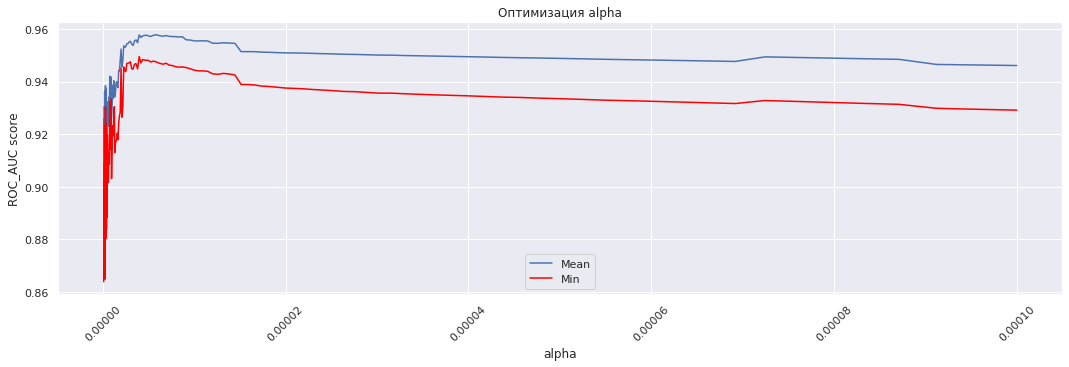

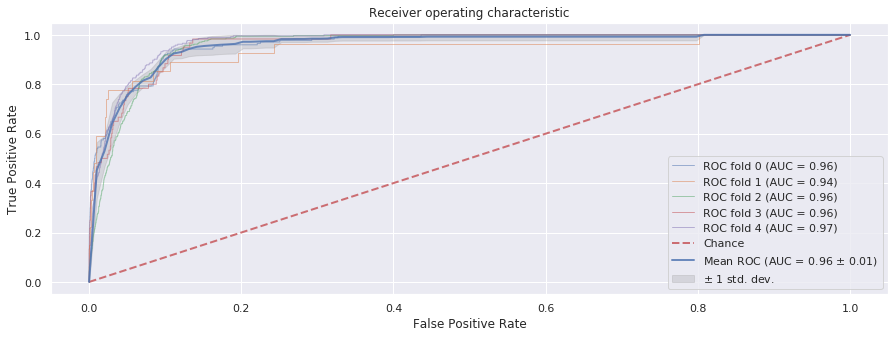

Scores         : 0.9578 (+/-0.0102) [0.9614, 0.9386, 0.9585, 0.9616, 0.969]
CPU times: user 21.6 s, sys: 3.53 s, total: 25.1 s
Wall time: 7min 28s


In [79]:
%%time

Z = TF_bin_scaled
X = csr_matrix(scipy.sparse.hstack([Z, F.values]))
search_range = np.logspace(-7, -4, 151)

parameters = dict([('alpha', search_range)])
clf = SGDClassifier(random_state=17, n_jobs=-1, loss='log', penalty='l2')

result_TF_bin_scaled = search_alpha(X[:n],
                                    y,
                                    parameters,
                                    clf_base=clf,
                                    cv=alice_cv,
                                    n_jobs=7)

### Сравнение ROC - кривых для базисных моделей.

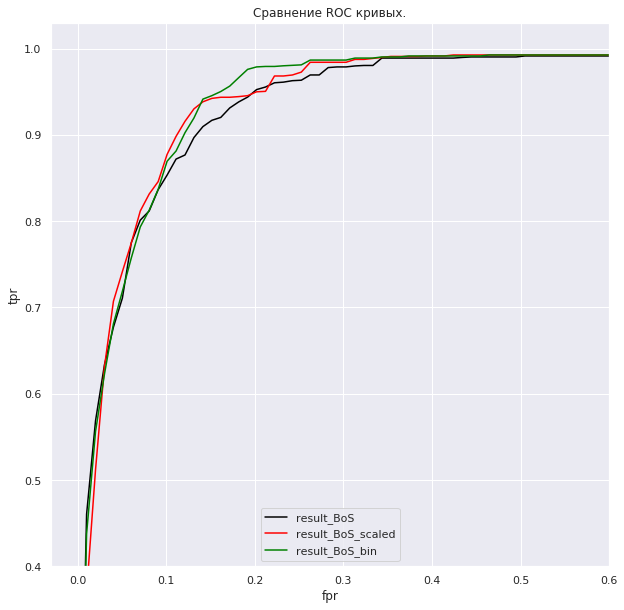

In [89]:
colors = ['black', 'red', 'green', 'blue', 'pink', 'brown', 'olive']
labels = ['result_BoS', 'result_BoS_scaled', 'result_BoS_bin']
results = [result_BoS, result_BoS_scaled, result_BoS_bin]
plt.figure(figsize=(10, 10))
[
    sns.lineplot(x=x[1], y=x[2], color=c, label=l)
    for x, c, l in zip(results, colors, labels)
]
plt.title("Сравнение ROC кривых.")
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.ylim(0.4, 1.03)
plt.xlim(-0.03, 0.6)
legend = plt.legend(loc='lower center')
plt.show()

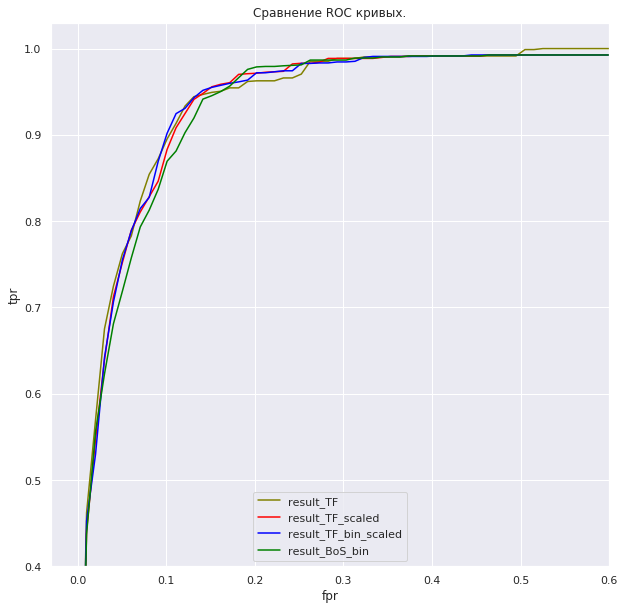

In [88]:
colors = ['olive', 'red', 'blue', 'green', 'pink', 'brown', 'coral']
labels = [
    'result_TF',
    'result_TF_scaled',
    #     'result_TF_bin',
    'result_TF_bin_scaled',
    'result_BoS_bin'
]
results = [
    result_TF,
    result_TF_scaled,
    #            result_TF_bin,
    result_TF_bin_scaled,
    result_BoS_bin
]
plt.figure(figsize=(10, 10))
[
    sns.lineplot(x=x[1], y=x[2], color=c, label=l)
    for x, c, l in zip(results, colors, labels)
]
plt.title("Сравнение ROC кривых.")
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.ylim(0.4, 1.03)
plt.xlim(-0.03, 0.6)
legend = plt.legend(loc='lower center')
plt.show()

### Save models

In [92]:
def get_o(name):
    with open(os.path.join(PATH_TO_DATA, name + '.pkl'), 'rb') as file:
        o = pickle.load(file)
    return o


def save_o(obj, name):
    with open(os.path.join(PATH_TO_DATA, name + '.pkl'), 'wb') as file:
        pickle.dump(obj, file, protocol=2)

In [96]:
names = [
    'Counter', 'Counter_Scaled', 'Counter_Binarized', 'Counter_TFIDF',
    'Counter_TFIDF_Scaled', 'Counter_Binarized_TFIDF',
    'Counter_Binarized_TFIDF_Scaled'
]
objects = [BoS, BoS_scaled, BoS_bin, TF, TF_scaled, TF_bin, TF_bin_scaled]

for o, n in zip(objects, names):
    save_o(o, n)

### Load data

In [52]:
names = [
    'Counter', 'Counter_Scaled', 'Counter_Binarized', 'Counter_TFIDF',
    'Counter_TFIDF_Scaled', 'Counter_Binarized_TFIDF',
    'Counter_Binarized_TFIDF_Scaled'
]

[
    Counter, Counter_Scaled, Counter_Binarized, Counter_TFIDF,
    Counter_TFIDF_Scaled, Counter_Binarized_TFIDF,
    Counter_Binarized_TFIDF_Scaled
] = [get_o(name) for name in names]
n = y.shape[0]

## Понижение размерности.

В нашей модели используется разреженная матрица, причем количество признаков намного превосходит количество данных.

В данных признаках содержатся малоинформативные, которые негативно влияют на качество модели.

Предлагается 3 способа понижения размерности: выбор наиболее часто посещаемых сайтов (параметр в CountVectorizer), выбор по модели (признаки с малыми коэффициентами удаляются), критерий $\chi^2$ (удаляются признаки, мало похжие)

#### function **selection**

In [53]:
def selection(X,
              y,
              selector,
              selection_parameters,
              clf_base,
              classification_parameters,
              n_jobs=-1,
              cv=alice_cv,
              verbose=True):
    """
    Feature selection by 'selector' and check scores by 'clf_base'.
    Returns scores for different number of features.
    """
    # number of training rows
    n = y.shape[0]

    # number of no-null features
    ns = []
    # scores for ns features
    scores = []

    pipline_selector = Pipeline([('selector', selector)])
    #     print(pipline_selector.get_params().keys())

    # find score for every feaure selection
    for key in selection_parameters.keys():
        for v in tqdm(selection_parameters[key]):
            # apply selector
            param = f'selector__{key}'
            pipline_selector.set_params(**{param: int(v)})
            # a new matrix after selection
            Y = pipline_selector.fit_transform(X[:n], y)
            # search best score for the new matrix
            clf = GridSearchCV(estimator=clf_base,
                               param_grid=classification_parameters,
                               cv=cv,
                               n_jobs=n_jobs)
            clf.fit(Y, y)
            score = cross_val_score(clf.best_estimator_,
                                    Y,
                                    y,
                                    scoring='roc_auc',
                                    cv=cv,
                                    n_jobs=n_jobs)
            # save found parameters
            ns.append(Y.shape[1])
            scores.append((score, clf.best_params_))
            # verbose = True
            if (verbose):
                print(f'Number of Features : {Y.shape[1]}' +
                      f'\nAUC score {round(np.mean(score),5)}\n')


# plot auc_score by alpha and number_of_features by alpha
#     print(scores)
    plot_scores_by_selection(ns, scores)

    return ns, scores


def plot_scores_by_selection(ns, y_scores):
    # plot cv-scores by number of left features
    y1 = np.mean([x[0] for x in y_scores], axis=1)
    y2 = [x[1]['alpha'] for x in y_scores]
    plt.figure(figsize=(10, 5))
    ax1 = sns.lineplot(ns, y1, color='green', label="cv-score")
    ax1.set_ylabel('ROC_AUC score')
    ax2 = ax1.twinx()
    sns.lineplot(ns, y2, color='red', label="alpha", ax=ax2)
    ax2.set_ylabel('alpha')
    ax1.set_xlabel('number of features')
    ax1.set_title('Feature selection')
    ax1.legend(loc='lower center')
    ax2.legend(loc='lower right')
    plt.show()

#### class **addF**

In [62]:
class addF:
    def __init__(self, F: np.array):
        self.F = F

    def fit(self, X, y):
        return self

    def transform(self, X):
        n = X.shape[0]
        return csr_matrix(scipy.sparse.hstack([X, self.F[:n]]))

    def fit_transform(self, X, y):
        n = X.shape[0]
        return csr_matrix(scipy.sparse.hstack([X, self.F[:n]]))

### Выбор признаков по модели.

Выбор признаков присходит по абсолютной величине кэффициентов обученной модели. Признакм должны быть нормированы.

selector with L2-regularization with alpha

#### Counter->Scaled

In [55]:
X = Counter_Scaled[:n]

In [70]:
# selection
alpha = 10**-6

selection_estimator = SGDClassifier(random_state=17,
                                    n_jobs=4,
                                    loss='log',
                                    penalty='l2',
                                    alpha=alpha)

selector = Pipeline(steps=[
    ('addf', addF(F[:n])),
    ('selectfrommodel',
     SelectFromModel(estimator=selection_estimator, max_features=150000)),
])
max_features_range = np.linspace(150 * 10**3, 10 * 10**3, 29)

In [57]:
# classifier for cv-score
clf_base = SGDClassifier(random_state=17, n_jobs=-1, loss='log', penalty='l2')
alpha_range = np.logspace(-6, -4, 81)

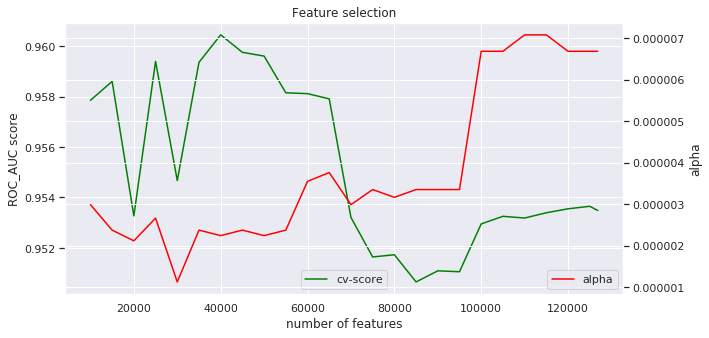

CPU times: user 4min 58s, sys: 46.9 s, total: 5min 44s
Wall time: 33min 54s


In [113]:
%%time

result_bymodel_Counter_Scaled = selection(
    X,
    y,
    selector,
    selection_parameters={'selectfrommodel__max_features': max_features_range},
    clf_base=clf_base,
    classification_parameters={'alpha': alpha_range},
    verbose=False,
    n_jobs=6)

In [114]:
save_o(result_bymodel_Counter_Scaled, 'selection_bymodel_Counter_Scaled')

In [162]:
d = result_bymodel_Counter_Scaled
scores = [(x, y[0], y[1]) for x, y in zip(d[0], d[1])]


In [163]:
scores = [(np.mean(x[1]), np.std(x[1]), x[0], x[2]) for x in scores]

С минимальной дисперсией

In [164]:
sorted(scores, key=lambda x: x[1])[0]

(0.9579102246472747,
 0.008734670960299423,
 65000,
 {'alpha': 3.7583740428844434e-06})

С максимальным значением метрики (скорее перебученная модель)

In [165]:
sorted(scores, key=lambda x: x[0], reverse=True)[0]

(0.9604483261653936,
 0.01220196044574727,
 40000,
 {'alpha': 2.2387211385683376e-06})

##### Kaggle

In [90]:
X = Counter_Scaled
text = "bymodel_Counter_Scaled"

In [91]:
selector = Pipeline(steps=[
    ('addf', addF(F)),
    ('selectfrommodel',
     SelectFromModel(estimator=selection_estimator, max_features=60000)),
])
selector.fit(X[:n], y)
X = selector.transform(X)

Fitting 5 folds for each of 101 candidates, totalling 505 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done 505 out of 505 | elapsed:  1.1min finished


{'alpha': 3.0499999999999996e-06} 0.959508909596335


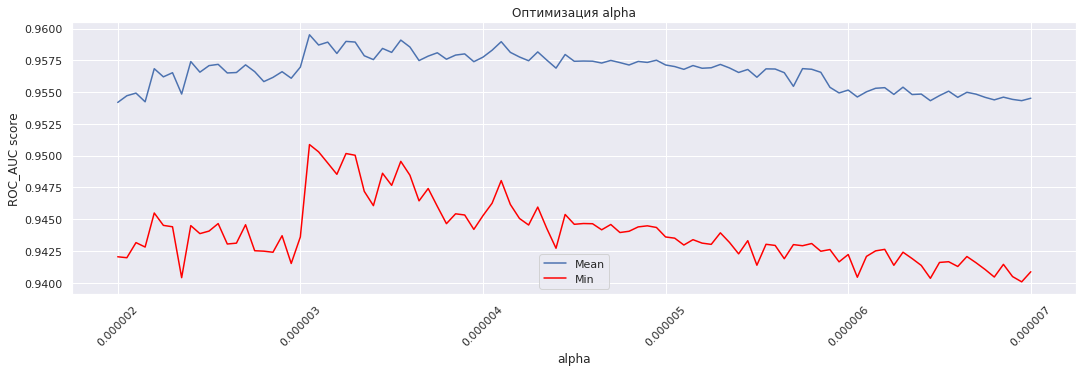

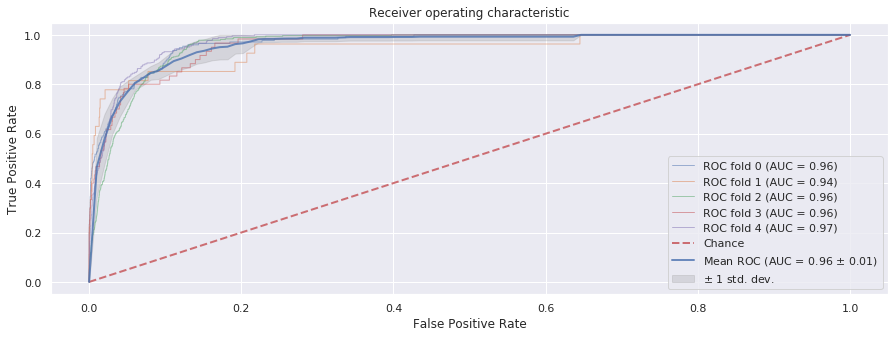

Scores         : 0.9595 (+/-0.0086) [0.9649, 0.9446, 0.9584, 0.9591, 0.9704]


In [92]:
search_range = np.linspace(2 * 10**-6, 7 * 10**-6, 101)
parameters = dict([('alpha', search_range)])

clf = SGDClassifier(random_state=17, n_jobs=-1, loss='log', penalty='l2')

bymodel_Counter_Scaled = search_alpha(X[:n],
                                      y,
                                      parameters,
                                      clf_base=clf,
                                      cv=alice_cv)

In [85]:
model = bymodel_Counter_Scaled[3]
model

SGDClassifier(alpha=2.8999999999999998e-06, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=17, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [80]:
# 0.9595 (+/-0.0068) [0.9623, 0.9486, 0.9572, 0.9599, 0.9696] -> 0.93944 (65k) (3.35*10**-6)
# 0.9620 (+/-0.0091) [0.9674, 0.9458, 0.9625, 0.961, 0.9731] -> 0.93857 (40k)

In [89]:
model.fit(X[:n], y)
proba = model.predict_proba(X[n:])
m.write_to_submission_file(proba[:, 1], f"{text}.csv")

#### Counter->Binarized

In [99]:
X = Counter_Binarized

In [105]:
# selection
alpha = 10**-5

selection_estimator = SGDClassifier(random_state=17,
                                    n_jobs=4,
                                    loss='log',
                                    penalty='l2',
                                    alpha=alpha)

selector = Pipeline(steps=[
    ('addf', addF(F)),
    ('selectfrommodel',
     SelectFromModel(estimator=selection_estimator, max_features=150000)),
])
max_features_range = np.linspace(150 * 10**3, 10 * 10**3, 29)

In [113]:
# classifier for cv-score
clf_base = SGDClassifier(random_state=17, n_jobs=-1, loss='log', penalty='l2')
alpha_range = np.logspace(-6, -4, 101)

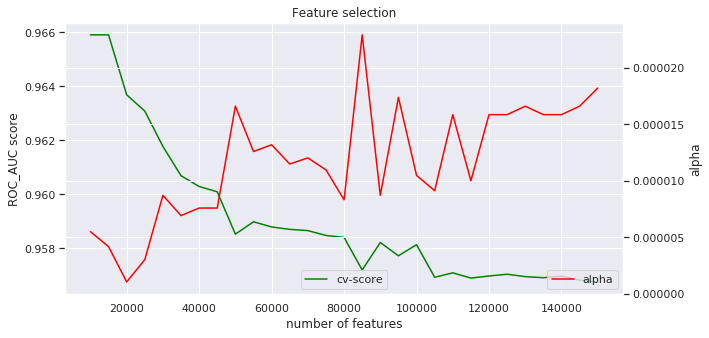

CPU times: user 5min, sys: 48.6 s, total: 5min 48s
Wall time: 38min 41s


In [114]:
%%time

result_bymodel_Counter_Binarized = selection(
    X[:n],
    y,
    selector,
    selection_parameters={'selectfrommodel__max_features': max_features_range},
    clf_base=clf_base,
    classification_parameters={'alpha': alpha_range},
    verbose=False,
    n_jobs=-1)

In [115]:
save_o(result_bymodel_Counter_Binarized, 'selection_bymodel_Counter_Binarized')

In [116]:
d = result_bymodel_Counter_Binarized
scores = [(x, y[0], y[1]) for x, y in zip(d[0], d[1])]


In [117]:
scores = [(np.mean(x[1]), np.std(x[1]), x[0], x[2]) for x in scores]

С минимальной дисперсией

In [118]:
sorted(scores, key=lambda x: x[1])[0]

(0.9636794223575087,
 0.006622560837832778,
 20000,
 {'alpha': 1.0471285480508985e-06})

С максимальным значением метрики (скорее перебученная модель)

In [119]:
sorted(scores, key=lambda x: x[0], reverse=True)[0]

(0.9659016027443545,
 0.009645756960099111,
 10000,
 {'alpha': 5.4954087385762485e-06})

##### Kaggle

In [120]:
X = Counter_Binarized
text = "bymodel_Counter_Binarized"

In [121]:
selector = Pipeline(steps=[
    ('addf', addF(F)),
    ('selectfrommodel',
     SelectFromModel(estimator=selection_estimator, max_features=20000)),
])
selector.fit(X[:n], y)
X = selector.transform(X)

Fitting 5 folds for each of 121 candidates, totalling 605 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 605 out of 605 | elapsed:  1.7min finished


{'alpha': 1.23e-06} 0.9644179808098654


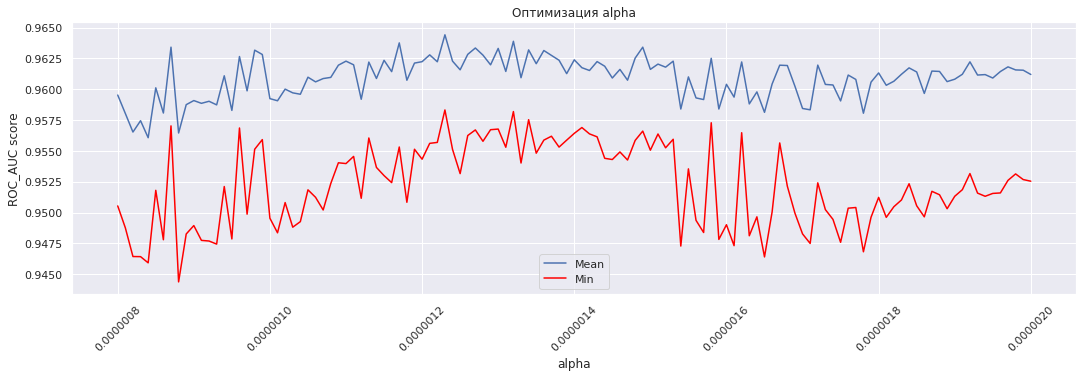

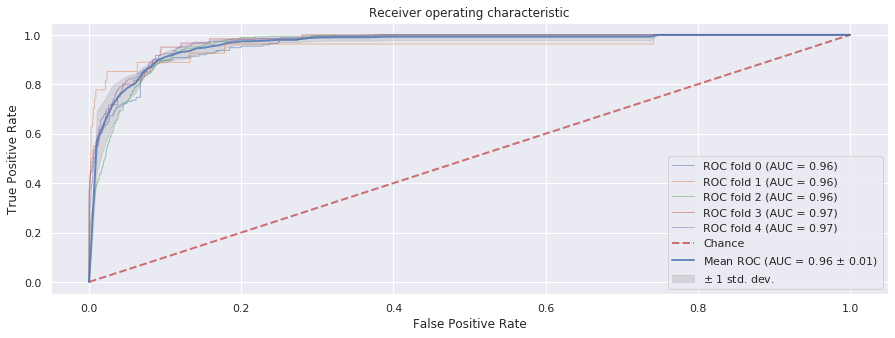

Scores         : 0.9644 (+/-0.0061) [0.9615, 0.9556, 0.9624, 0.9716, 0.971]


In [123]:
search_range = np.linspace(0.8 * 10**-6, 2 * 10**-6, 121)
parameters = dict([('alpha', search_range)])

clf = SGDClassifier(random_state=17, n_jobs=-1, loss='log', penalty='l2')

bymodel_Counter_Binarized = search_alpha(X[:n],
                                         y,
                                         parameters,
                                         clf_base=clf,
                                         cv=alice_cv)

In [124]:
model = bymodel_Counter_Binarized[3]
model

SGDClassifier(alpha=1.23e-06, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=17, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [80]:
# 0.9644 (+/-0.0061) [0.9615, 0.9556, 0.9624, 0.9716, 0.971] -> 0.94143

In [125]:
model.fit(X[:n], y)
proba = model.predict_proba(X[n:])
m.write_to_submission_file(proba[:, 1], f"{text}.csv")

### Критерий $\chi^2$

#### Counter->binarized

In [62]:
X = Counter_Binarized

In [63]:
X.shape , F.shape

((336358, 2975923), (336358, 5))

In [86]:
# paremeters for selection
selector = Pipeline(steps=[('selectkbest',
                            SelectKBest(score_func=chi2)), ('addf',
                                                            addF(F[:n]))])
k_range = np.linspace(150 * 10**3, 10 * 10**3, 29)
# classifier for cv-score
clf_base = SGDClassifier(random_state=17, n_jobs=-1, loss='log', penalty='l2')
alpha_range = np.logspace(-6, -4, 81)

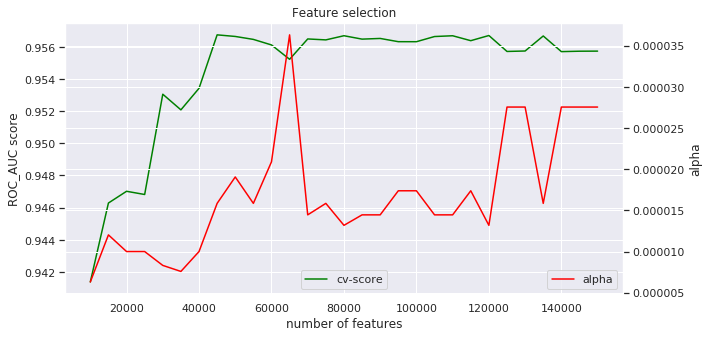

CPU times: user 2min 58s, sys: 29.5 s, total: 3min 27s
Wall time: 28min 11s


In [72]:
%%time

result_Counter_Binarized = selection(
    X,
    y,
    selector,
    selection_parameters={'selectkbest__k': k_range},
    clf_base=clf_base,
    classification_parameters={'alpha': alpha_range},
    verbose=False,
    n_jobs=-1)

#### Counter->TFIDF->scaled

In [82]:
X = Counter_TFIDF_Scaled

In [83]:
X.shape , F.shape

((336358, 2975923), (336358, 5))

In [84]:
# paremeters for selection
selector = Pipeline(steps=[('selectkbest',
                            SelectKBest(score_func=chi2)), ('addf',
                                                            addF(F[:n]))])
k_range = np.linspace(150 * 10**3, 10 * 10**3, 29)
# classifier for cv-score
clf_base = SGDClassifier(random_state=17, n_jobs=-1, loss='log', penalty='l2')
alpha_range = np.logspace(-6, -4, 81)

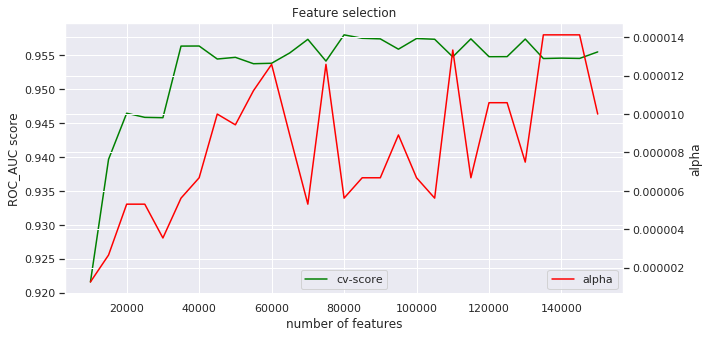

CPU times: user 3min 55s, sys: 42.8 s, total: 4min 37s
Wall time: 40min 9s


In [85]:
%%time

Counter_TFIDF_Scaled = selection(
    X,
    y,
    selector,
    selection_parameters={'selectkbest__k': k_range},
    clf_base=clf_base,
    classification_parameters={'alpha': alpha_range},
    verbose=False,
    n_jobs=7)

#### Counter->binarized->TFIDF->scaled

In [64]:
X = TF_bin_scaled
alpha = alpha_Counter_bin_TFIDF_scaled

In [65]:
selector = SelectKBest(score_func=chi2)
k_range = np.linspace(10**4, 1.5 * 10**5, 29)
clf_base = SGDClassifier(random_state=17,
                         n_jobs=-1,
                         loss='log',
                         penalty='l2',
                         alpha=alpha)

100%|██████████| 29/29 [01:22<00:00,  2.83s/it]


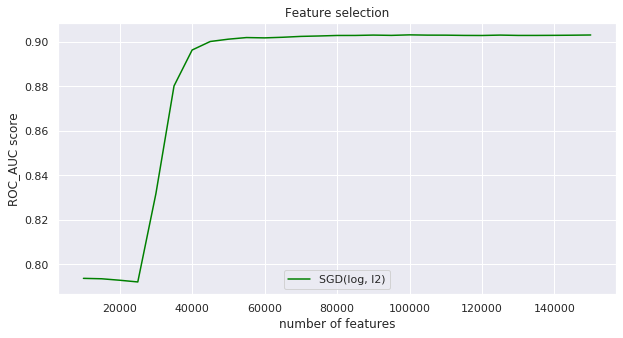

CPU times: user 1min 26s, sys: 4.13 s, total: 1min 31s
Wall time: 1min 22s


In [66]:
%%time

result_TF_bin_scaled = selection(X,
                                 y,
                                 selector, {'k': k_range},
                                 clf_base,
                                 None,
                                 verbose=False)

#### Сравнение

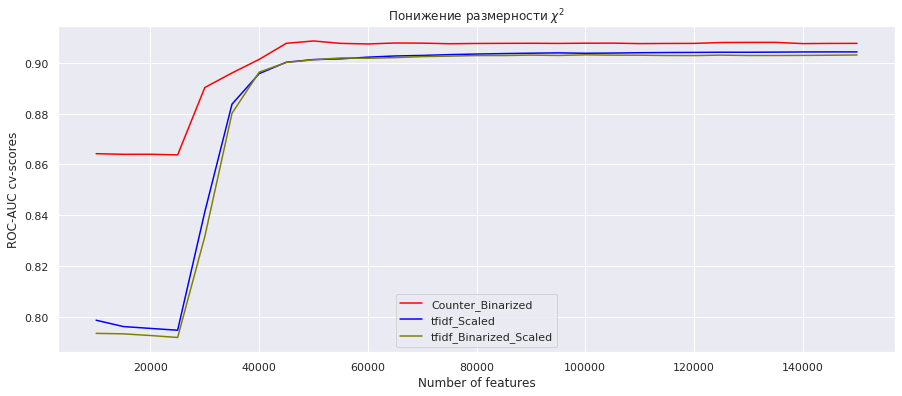

In [67]:
colors = ['red', 'blue', 'olive']
labels = ['Counter_Binarized', 'tfidf_Scaled', 'tfidf_Binarized_Scaled']
results = [result_BoS_bin, result_TF_scaled, result_TF_bin_scaled]
plt.figure(figsize=(15, 6))
[
    sns.lineplot(x=x[0], y=x[2], color=c, label=l)
    for x, c, l in zip(results, colors, labels)
]
plt.title("Понижение размерности $\chi^2$")
plt.xlabel('Number of features')
plt.ylabel('ROC-AUC cv-scores')
legend = plt.legend(loc='lower center')
plt.show()

### Часто посещаемые сайты

Класс для выбора количества сайтов

In [68]:
X = train_test[sites_columns]

###### Класс MostVisited

In [122]:
class MostVisited:
    def __init__(self, n_features=1000):
        self.n_features = n_features
        self.vectorizer = CountVectorizer(ngram_range=N_GRAMMS,
                                          token_pattern='\w+',
                                          max_features=self.n_features)

    def fit(self, X, y):
        n = y.shape[0]
        docs = [" ".join(map(str, row)) for row in X]
        self.vectorizer.fit(docs[:n], y)
        return self

    def transform(self, X):
        docs = [" ".join(map(str, row)) for row in X]
        return self.vectorizer.transform(docs)

    def fit_transform(self, X, y):
        n = y.shape[0]
        docs = [" ".join(map(str, row)) for row in X]
        return self.vectorizer.fit(docs[:n], y).transform(docs[:n])


#     set params to self.vectorizer

    def set_params(self, n_features=1000):
        self.vectorizer.set_params(**{'max_features': n_features})

#### Counter ->  Binarized

In [70]:
X = train_test[sites_columns]

In [71]:
alpha = alpha_Counter_bin

In [72]:
selector = Pipeline(steps=[('mostvisited',
                            MostVisited()), ('binarization', Binarizer())])

n_features_range = np.linspace(10**4, 1.2 * 10**5, 23)
clf_base = SGDClassifier(random_state=17,
                         n_jobs=4,
                         loss='log',
                         penalty='l2',
                         alpha=alpha)

100%|██████████| 23/23 [13:46<00:00, 35.94s/it]


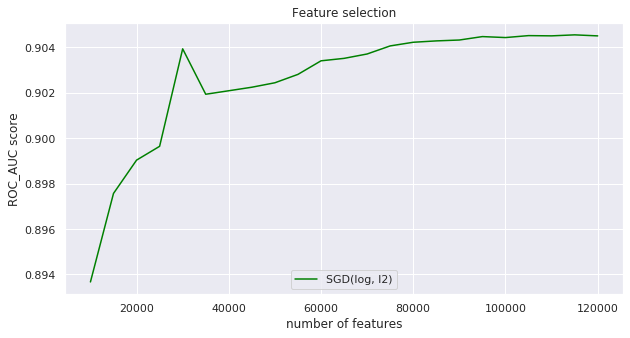

CPU times: user 13min 33s, sys: 16 s, total: 13min 49s
Wall time: 13min 47s


In [73]:
%%time

result_counter_bin_mv = selection(
    X.values[:n],
    y.values,
    selector, {'mostvisited__n_features': n_features_range},
    clf_base,
    None,
    verbose=False)

#### Counter -> TF-IDF->Scaled

In [74]:
alpha = alpha_Counter_TFIDF_scaled

In [75]:
selector = Pipeline(
    steps=[('mostvisited', MostVisited()),
           ('tfidf',
            TfidfTransformer(norm='l2', sublinear_tf=True, use_idf=True)
            ), ('scaler', MaxAbsScaler())])

n_features_range = np.linspace(10**4, 1.2 * 10**5, 23)
clf_base = SGDClassifier(random_state=17,
                         n_jobs=4,
                         loss='log',
                         penalty='l2',
                         alpha=alpha)

100%|██████████| 23/23 [14:43<00:00, 38.43s/it]


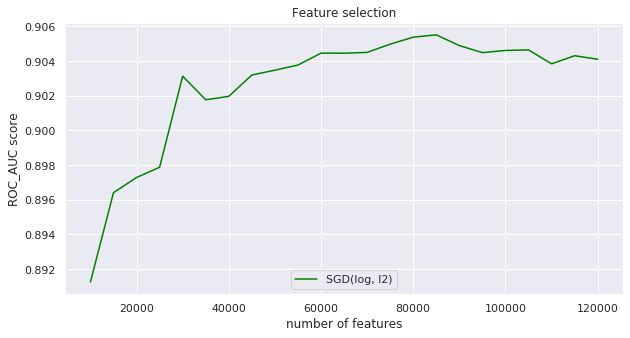

CPU times: user 14min 29s, sys: 16.9 s, total: 14min 46s
Wall time: 14min 44s


In [76]:
%%time

result_counter_TF_scaled_mv = selection(
    X.values[:n],
    y.values,
    selector, {'mostvisited__n_features': n_features_range},
    clf_base,
    None,
    verbose=False,
    n_jobs=-1)

#### Counter Binarized -> TF-IDF ->Scaled

In [77]:
alpha = alpha_Counter_bin_TFIDF_scaled

In [78]:
selector = Pipeline(
    steps=[('mostvisited',
            MostVisited()), ('binarization',
                                                   Binarizer()),
           ('tfidf',
            TfidfTransformer(norm='l2', sublinear_tf=True, use_idf=True)
            ), ('scaler', MaxAbsScaler())])

n_features_range = np.linspace(10**4, 1.2 * 10**5, 23)
clf_base = SGDClassifier(random_state=17,
                         n_jobs=4,
                         loss='log',
                         penalty='l2',
                         alpha=alpha)

100%|██████████| 23/23 [16:06<00:00, 42.01s/it]


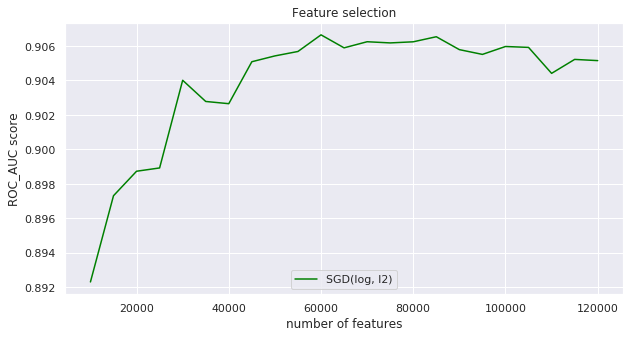

CPU times: user 15min 45s, sys: 19.3 s, total: 16min 5s
Wall time: 16min 6s


In [79]:
%%time

result_counter_bin_TF_scaled = selection(
    X.values[:n],
    y.values,
    selector, {'mostvisited__n_features': n_features_range},
    clf_base,
    None,
    verbose=False,
    n_jobs=-1)

#### Сравнение

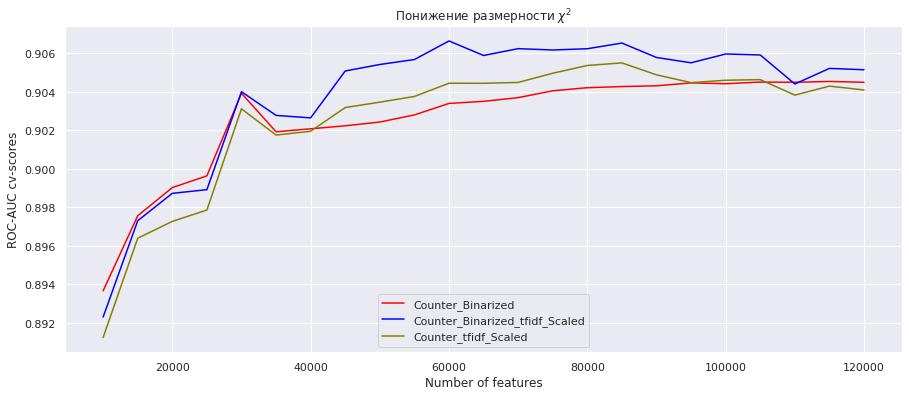

In [80]:
colors = ['red', 'blue', 'olive']
labels = [
    'Counter_Binarized', 'Counter_Binarized_tfidf_Scaled',
    'Counter_tfidf_Scaled'
]
results = [
    result_counter_bin_mv, result_counter_bin_TF_scaled,
    result_counter_TF_scaled_mv
]
plt.figure(figsize=(15, 6))
[
    sns.lineplot(x=x[0], y=x[2], color=c, label=l)
    for x, c, l in zip(results, colors, labels)
]
plt.title("Понижение размерности $\chi^2$")
plt.xlabel('Number of features')
plt.ylabel('ROC-AUC cv-scores')
legend = plt.legend(loc='lower center')
plt.show()

### Most Visited +$\chi^2$

select 100k most visited sites

In [124]:
X = train_test[sites_columns]

selector = MostVisited(n_features=10**5)
selector.fit(X.values[:n], y.values)
X = selector.transform(X.values)
alpha = alpha_Counter_bin_TFIDF_scaled

In [125]:
selector = Pipeline(steps=[('binarization', Binarizer(
)), ('tfidf', TfidfTransformer(norm='l2', sublinear_tf=True, use_idf=True)
     ), ('scaler', MaxAbsScaler()), ('chi2', SelectKBest(score_func=chi2))])

In [126]:
k_range = np.linspace(10**4, 10**5, 19)
clf_base = SGDClassifier(random_state=17,
                         n_jobs=-1,
                         loss='log',
                         penalty='l2',
                         alpha=alpha)

100%|██████████| 19/19 [00:50<00:00,  2.66s/it]


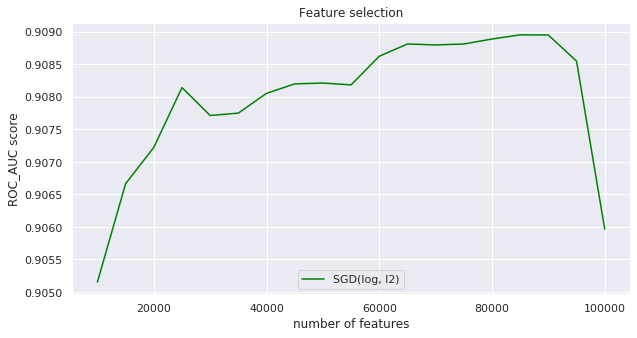

CPU times: user 48.4 s, sys: 4.22 s, total: 52.6 s
Wall time: 51 s


In [127]:
%%time

result_counter_bin_TF_scaled_chi2 = selection(X[:n],
                                              y,
                                              selector, {'chi2__k': k_range},
                                              clf_base,
                                              None,
                                              verbose=False,
                                              n_jobs=-1)

#### Сравнение 

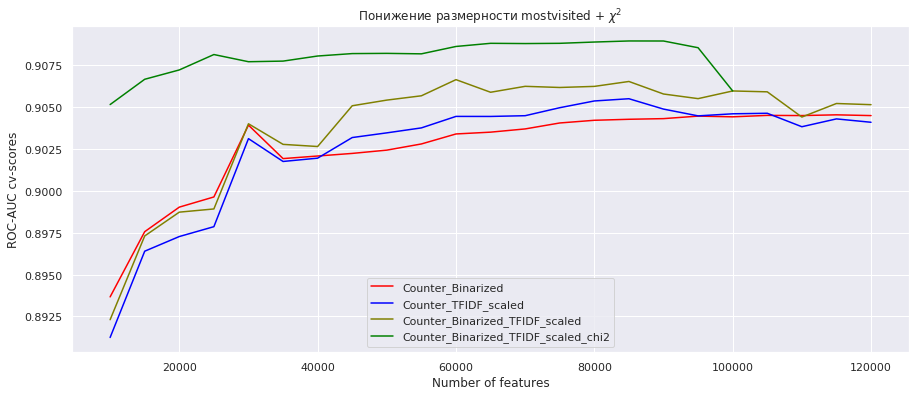

In [128]:
colors = ['red', 'blue', 'olive', 'green']
labels = [
    'Counter_Binarized', 'Counter_TFIDF_scaled',
    'Counter_Binarized_TFIDF_scaled', 'Counter_Binarized_TFIDF_scaled_chi2'
]
results = [
    result_counter_bin_mv, result_counter_TF_scaled_mv,
    result_counter_bin_TF_scaled, result_counter_bin_TF_scaled_chi2
]
plt.figure(figsize=(15, 6))
[
    sns.lineplot(x=x[0], y=x[2], color=c, label=l)
    for x, c, l in zip(results, colors, labels)
]
plt.title("Понижение размерности mostvisited + $\chi^2$")
plt.xlabel('Number of features')
plt.ylabel('ROC-AUC cv-scores')
legend = plt.legend(loc='lower center')
plt.show()

#### Final model of BagOfSites

In [129]:
X = train_test[sites_columns]
X.shape

(336358, 10)

In [130]:
selector = Pipeline(
    steps=[('mostvisited',
            MostVisited(n_features=100000)), ('binarization', Binarizer()),
           ('tfidf',
            TfidfTransformer(norm='l2', sublinear_tf=True, use_idf=True)
            ), ('scaler',
                MaxAbsScaler()), ('chi2',
                                  SelectKBest(score_func=chi2, k=85000))])

In [131]:
%%time

selector.fit(X.values[:n], y)
X_new = selector.transform(X.values)

CPU times: user 57.4 s, sys: 944 ms, total: 58.3 s
Wall time: 58.3 s


In [132]:
X_new

<336358x85000 sparse matrix of type '<class 'numpy.float64'>'
	with 5664698 stored elements in Compressed Sparse Row format>

Fitting 5 folds for each of 201 candidates, totalling 1005 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1005 out of 1005 | elapsed:  3.3min finished


{'alpha': 1.0292005271944286e-05} 0.9093175625516532


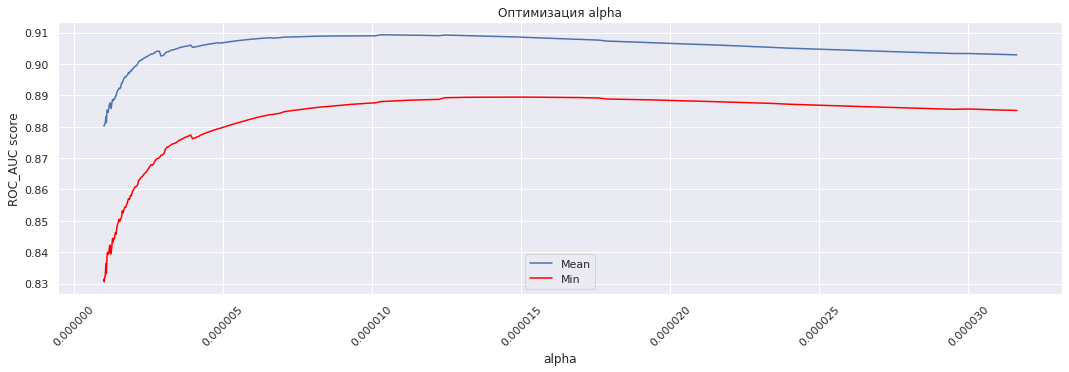

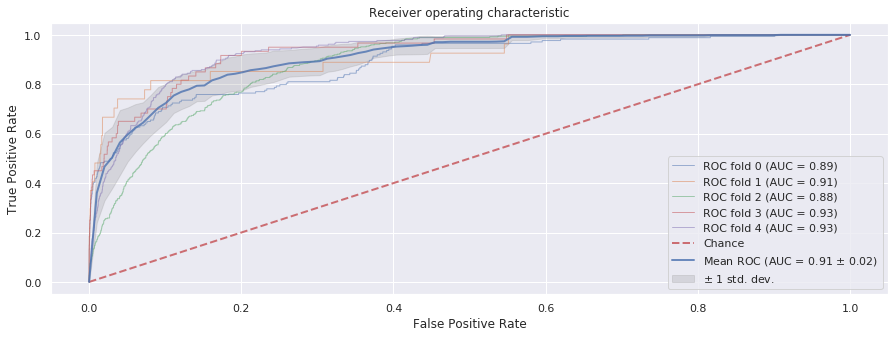

Scores         : 0.9093 (+/-0.0213) [0.8856, 0.9132, 0.8836, 0.9324, 0.9317]
CPU times: user 22.8 s, sys: 3.87 s, total: 26.6 s
Wall time: 3min 21s


In [134]:
%%time

X = X_new

search_range = np.logspace(-6, -4.5, 201)
parameters = dict([('alpha', search_range)])
clf = SGDClassifier(random_state=17, n_jobs=-1, loss='log')

result_sites = search_alpha(X[:n], y, parameters, clf_base=clf, cv=alice_cv)

Fitting 5 folds for each of 121 candidates, totalling 605 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 605 out of 605 | elapsed:  1.8min finished


{'alpha': 1.02e-05} 0.909329699043116


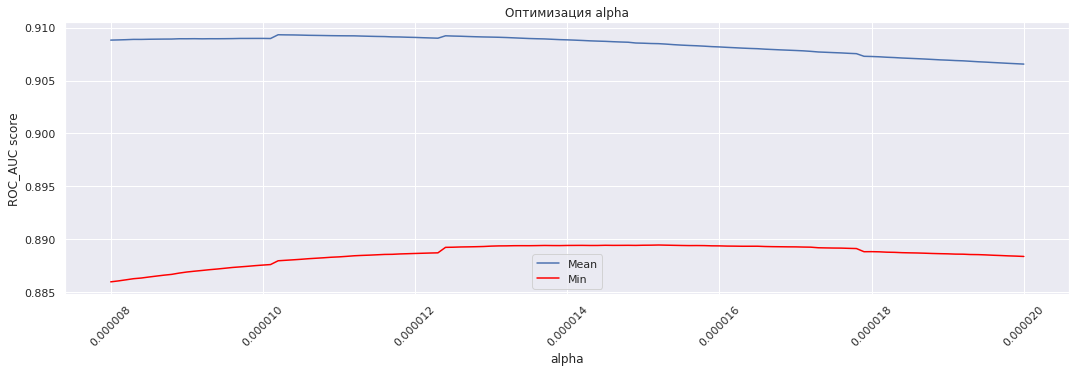

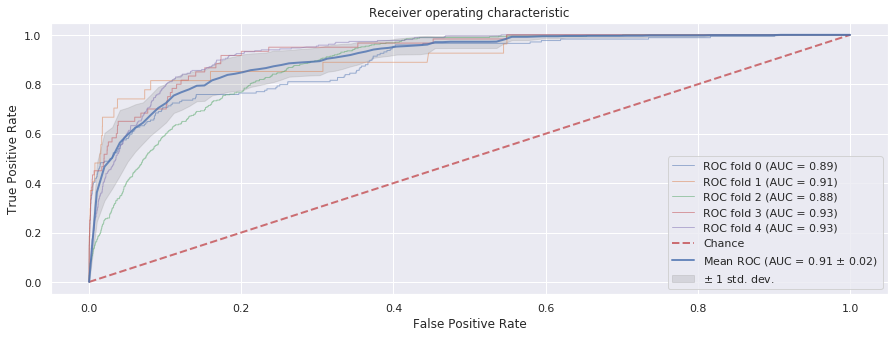

Scores         : 0.9093 (+/-0.0214) [0.8855, 0.9135, 0.8836, 0.9324, 0.9317]
CPU times: user 17.1 s, sys: 2.73 s, total: 19.9 s
Wall time: 1min 53s


In [141]:
%%time

search_range = np.linspace(0.8 * 10**-5, 2 * 10**-5, 121)
parameters = dict([('alpha', search_range)])
clf = SGDClassifier(random_state=17, n_jobs=-1, loss='log')

result_sites = search_alpha(X[:n], y, parameters, clf_base=clf, cv=alice_cv)

In [ ]:
# {'alpha': 1.3375e-06} 0.9105354419792411 np.linspace(1 * 10**-6, 5 * 10**-6, 321)
# 0.9105 (+/-0.0233) [0.8884, 0.9265, 0.877, 0.9356, 0.9252] -> 0.92191

In [142]:
text = "c_mv_b_tf_s_chi2"
result = result_sites

In [143]:
X = train_test[sites_columns]

In [144]:
model = result[3]
X = X_new

In [145]:
X

<336358x85000 sparse matrix of type '<class 'numpy.float64'>'
	with 5664698 stored elements in Compressed Sparse Row format>

In [146]:
model

SGDClassifier(alpha=1.02e-05, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=17, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [147]:
model.fit(X[:n], y)
proba = model.predict_proba(X[n:])
m.write_to_submission_file(proba[:, 1], f"{text}.csv")  # 0.92064

In [148]:
X_new

<336358x85000 sparse matrix of type '<class 'numpy.float64'>'
	with 5664698 stored elements in Compressed Sparse Row format>

## Add New features

In [60]:
train_test[daytime + ['dayofweek', 'month']].head()

,morning,day,evening,dayofweek,month
session_id,,,,,
21669,1,0,0,1.682905,-0.943567
54843,1,0,0,1.682905,-0.943567
77292,1,0,0,1.682905,-0.943567
114021,1,0,0,1.682905,-0.943567
146670,1,0,0,1.682905,-0.943567


### DAYTIME+DAYOFWEEK_scaled +MONTH_scaled

In [61]:
X_new

NameError: name 'X_new' is not defined

In [169]:
X = csr_matrix(
    scipy.sparse.hstack([X_new, train_test[daytime + ['dayofweek', 'month']]]))

In [154]:
X

<336358x85005 sparse matrix of type '<class 'numpy.float64'>'
	with 6673772 stored elements in Compressed Sparse Row format>

In [155]:
%%time

model = SGDClassifier(random_state=17,
                      n_jobs=-1,
                      loss='log',
                      alpha=1.3375 * 10**-6)

model_assessment(model, X[:n], y, alice_cv, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.6s remaining:    3.9s


ROC_AUC score: : 0.9517 (+/-0.0057) [0.9536, 0.9444, 0.9486, 0.9613, 0.9505]
CPU times: user 148 ms, sys: 872 ms, total: 1.02 s
Wall time: 3.15 s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


array([0.95364742, 0.94437527, 0.94861907, 0.9613066 , 0.95050698])

In [310]:
# +datetime + dayofweek_scaled
# 0.9479 (+/-0.0197) [0.9549, 0.9393, 0.915, 0.9575, 0.9731] -> 0.95070

In [309]:
# +datetime + month_scaled
# 0.9471 (+/-0.0169) [0.9573, 0.9423, 0.916, 0.9588, 0.9612] -> 

Fitting 5 folds for each of 161 candidates, totalling 805 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 805 out of 805 | elapsed:  3.2min finished


{'alpha': 9.440608762859225e-06} 0.9596990938047751


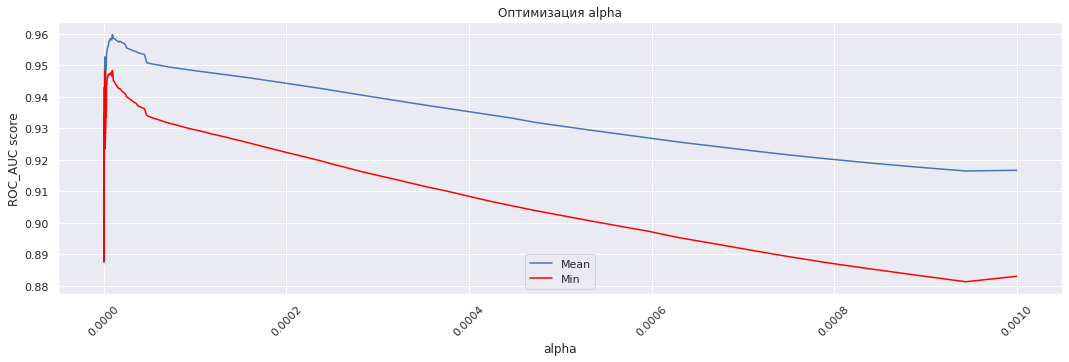

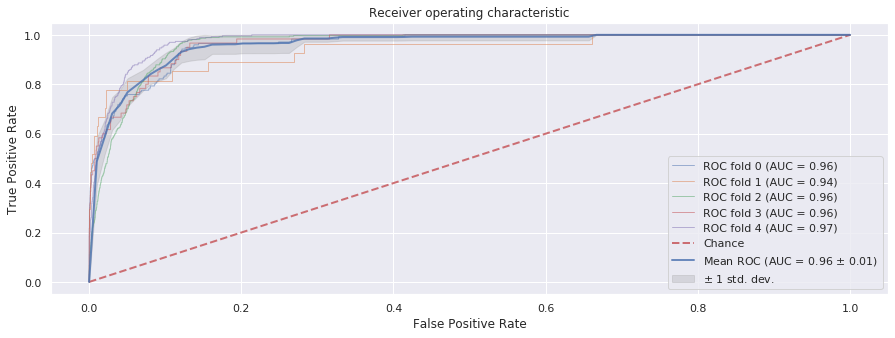

Scores         : 0.9597 (+/-0.0114) [0.9604, 0.9394, 0.9614, 0.9626, 0.9748]
CPU times: user 19.2 s, sys: 3.3 s, total: 22.5 s
Wall time: 3min 14s


In [156]:
%%time

search_range = np.logspace(-7, -3, 161)
parameters = dict([('alpha', search_range)])
clf = SGDClassifier(random_state=17, n_jobs=-1, loss='log')

result_f = search_alpha(X[:n], y, parameters, clf_base=clf, cv=alice_cv)

Fitting 5 folds for each of 161 candidates, totalling 805 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 805 out of 805 | elapsed:  2.9min finished


{'alpha': 8.95e-06} 0.9599527407396954


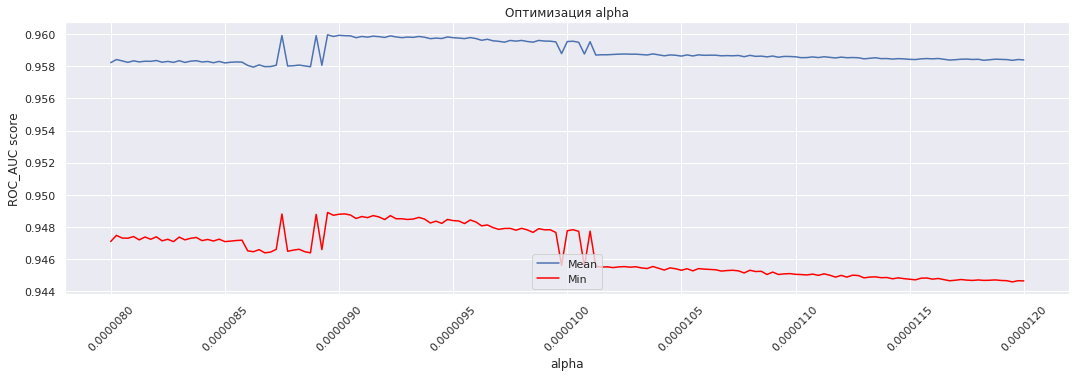

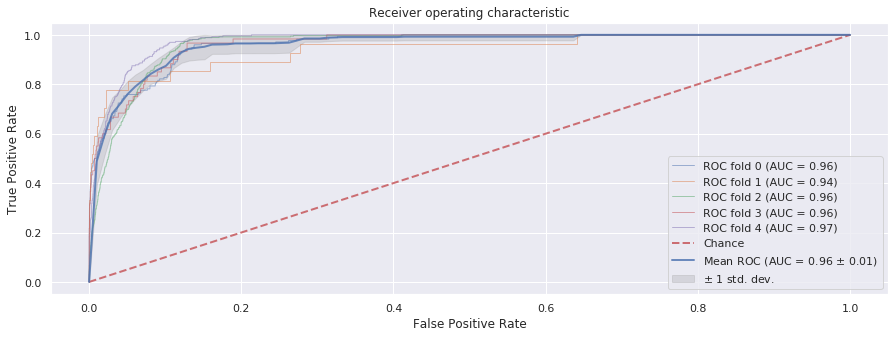

Scores         : 0.9600 (+/-0.0110) [0.9603, 0.9405, 0.9611, 0.9631, 0.9748]
CPU times: user 21.2 s, sys: 3.86 s, total: 25.1 s
Wall time: 2min 57s


In [161]:
%%time

search_range = np.linspace(0.8 * 10**-5, 1.2 * 10**-5, 161)
parameters = dict([('alpha', search_range)])
clf = SGDClassifier(random_state=17, n_jobs=-1, loss='log')

result_f = search_alpha(X[:n], y, parameters, clf_base=clf, cv=alice_cv)

In [312]:
result_daytime_dayofweek_scaled_month_scaled = result_day_time_scaled

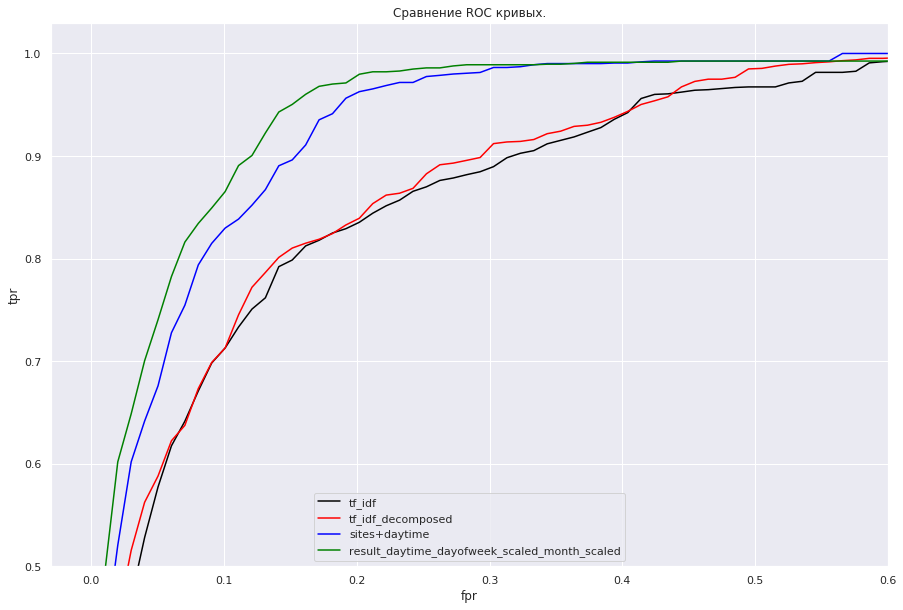

In [315]:
colors = ['black', 'red', 'blue', 'green', 'pink']
labels = [
    'tf_idf', 'tf_idf_decomposed', 'sites+daytime',
    'result_daytime_dayofweek_scaled_month_scaled'
]
results = [
    result_tfidf, result_sites, result_sites_datetime,
    result_daytime_dayofweek_scaled_month_scaled
]
plt.figure(figsize=(15, 10))
[
    sns.lineplot(x=x[1], y=x[2], color=c, label=l)
    for x, c, l in zip(results, colors, labels)
]
plt.title("Сравнение ROC кривых.")
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.ylim(0.5, 1.03)
plt.xlim(-0.03, 0.6)
legend = plt.legend(loc='lower center')
plt.show()

In [162]:
text = "f"
model = result_f[3]

In [163]:
model

SGDClassifier(alpha=8.95e-06, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=17, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [164]:
X

<336358x85005 sparse matrix of type '<class 'numpy.float64'>'
	with 6673772 stored elements in Compressed Sparse Row format>

In [165]:
model.fit(X[:n], y)
proba = model.predict_proba(X[n:])
m.write_to_submission_file(proba[:, 1], f"{text}.csv")  # 0.95288

In [ ]:
# datetime + dayofweek_scaled 
# 0.9537 (+/-0.0147) [0.9538, 0.9359, 0.941, 0.9608, 0.9771] -> 0.95350
# datetime + dayofweek_scaled + month_scaled
# 0.9618 (+/-0.0082) [0.9639, 0.9602, 0.9485, 0.9623, 0.9741] -> 0.93918

In [330]:
result_daytime_dayofweek_scaled_month_scaled_left = result_day_time_scaled

In [328]:
X_daytime_dayofweek_scaled_month_scaled_left = X

In [329]:
X_daytime_dayofweek_scaled_month_scaled_left

<336358x75005 sparse matrix of type '<class 'numpy.float64'>'
	with 6564283 stored elements in Compressed Sparse Row format>

In [332]:
text = "datetime+dayofweek_scaled_month_scaled_left"
model = result_daytime_dayofweek_scaled_month_scaled_left[3]

In [333]:
model

SGDClassifier(alpha=2.2799999999999998e-07, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=17, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [334]:
model.fit(X_daytime_dayofweek_scaled_month_scaled[:n], y)
proba = model.predict_proba(X[n:])
m.write_to_submission_file(proba[:, 1], f"{text}.csv") # 0.93918

In [380]:
X

<336358x75005 sparse matrix of type '<class 'numpy.float64'>'
	with 6564283 stored elements in Compressed Sparse Row format>

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  1.7min finished


{'alpha': 1.2099999999999998e-06} 0.9580652092924309


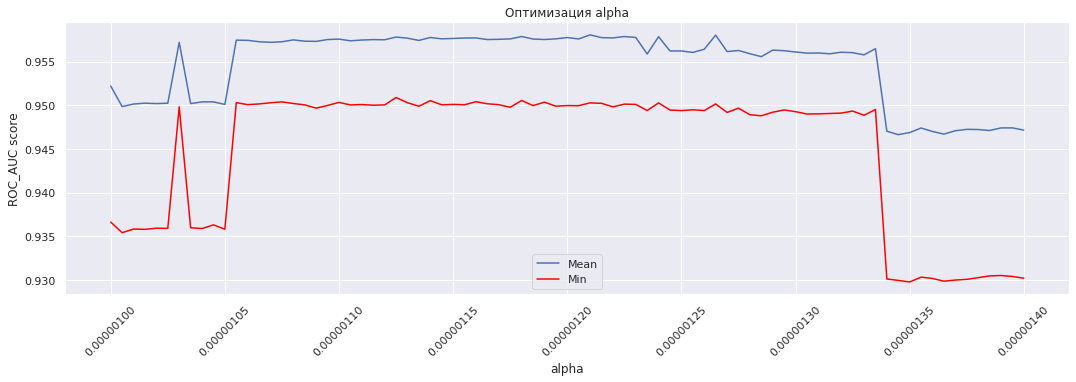

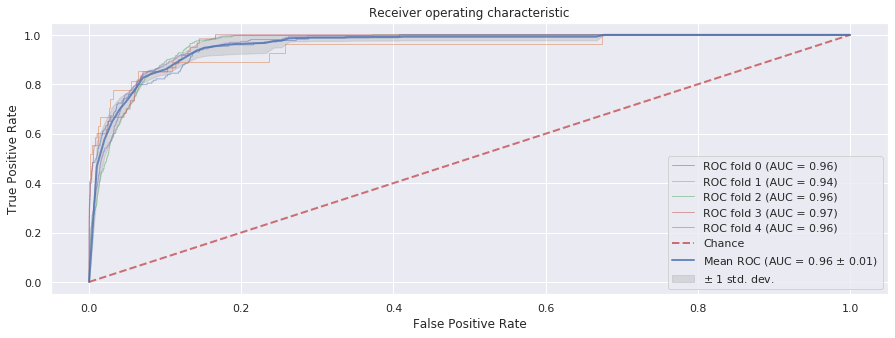

Scores         : 0.9581 (+/-0.0078) [0.9592, 0.9434, 0.961, 0.9667, 0.96]
CPU times: user 11.8 s, sys: 1.45 s, total: 13.3 s
Wall time: 1min 49s


In [384]:
%%time

search_range = np.linspace(1.0 * 10**-6, 1.4* 10**-6, 81)
parameters = dict([('alpha', search_range)])
clf = SGDClassifier(random_state=17, n_jobs=-1, loss='log')

result_daytime_dayofweek_scaled_month_scaled_right = search_alpha(X[:n],
                                                                  y,
                                                                  parameters,
                                                                  clf_base=clf,
                                                                  cv=alice_cv)

In [ ]:
# datetime + dayofweek_scaled 
# 0.9537 (+/-0.0147) [0.9538, 0.9359, 0.941, 0.9608, 0.9771] -> 0.95350

# datetime + dayofweek_scaled + month_scaled
# 0.9522 (+/-0.0156) [0.958, 0.9446, 0.9255, 0.9659, 0.967] -> 0.94903

# datetime + dayofweek_scaled + month_scaled
# {'alpha': 1.265e-06} 0.958032358105531
# 0.9580 (+/-0.0079) [0.9591, 0.9431, 0.9612, 0.9664, 0.9604] -> 
# {'alpha': 1.2099999999999998e-06} 0.9580652092924309
# 0.9581 (+/-0.0078) [0.9592, 0.9434, 0.961, 0.9667, 0.96] -> 0.94940

In [363]:
X_daytime_dayofweek_scaled_month_scaled

<336358x75005 sparse matrix of type '<class 'numpy.float64'>'
	with 6564283 stored elements in Compressed Sparse Row format>

In [369]:
result_daytime_dayofweek_scaled_month_scaled_right[3]

SGDClassifier(alpha=1.265e-06, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=17, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [386]:
%%time

model = SGDClassifier(random_state=17,
                      n_jobs=-1,
                      loss='log',
                      alpha=1.21 * 10**-6)

model_assessment(model, X[:n], y, alice_cv, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.0s


ROC_AUC score: : 0.9581 (+/-0.0078) [0.9592, 0.9434, 0.961, 0.9667, 0.96]
CPU times: user 129 ms, sys: 53.2 ms, total: 182 ms
Wall time: 1.97 s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


array([0.95921718, 0.94340688, 0.96098323, 0.96670001, 0.96001874])

In [387]:
text = "datetime+dayofweek_scaled_month_scaled_0_9581"
model = SGDClassifier(random_state=17,
                      n_jobs=-1,
                      loss='log',
                      alpha=1.21 * 10**-6)

In [388]:
model

SGDClassifier(alpha=1.2099999999999998e-06, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=17, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [352]:
model.fit(X_daytime_dayofweek_scaled_month_scaled[:n], y)
proba = model.predict_proba(X[n:])
m.write_to_submission_file(proba[:, 1], f"{text}.csv") # 0.9581 -> 0.94940

# Оценка модели с описанием выбранной метрики. Опишите простыми словами качество модели, как она может применяться

В данной модели выбрана метрика AUC.
AUC ROC равен доле пар объектов вида (объект класса 1, объект класса 0), которые алгоритм верно упорядочил, т.е. первый объект идёт в упорядоченном списке раньше.

AUC ROC можно использовать для оценки качества признаков. Считаем, что значения признака — это ответы нашего алгоритма (не обязательно они должны быть нормированы на отрезок [0, 1], ведь нам важен порядок). Тогда выражение 2×|AUC_ROC — 0.5| вполне подойдёт для оценки качества признака: оно максимально, если по этому признаку 2 класса строго разделяются и минимально, если они «перемешаны».

При изменении баланса классов величина AUC-ROC и неизменных свойствах объектов вы-борки площадь под ROC-кривой не изменится. В случае идеального алгоритма AUC−ROC= 1, а в случаехудшего AUC−ROC=0,5.Значение AUC−ROCимеет смысл вероятности того, что если были выбраны случайный положительный ислучайный отрицаельный объекты выборки, положительный объект получит оценку принадлежности выше,чем отрицательный объект.

В итоге, данная метрика стабильна относительно ввода большего количества пользователей, которые нарушают баланс классов.

# Выводы: как построенная модель может применяться на практике, какие бизнес-задачи решать. Подведите итог, опишите, что еще можно сделать, а что сделать не удалось.

Применимость выходит из выбранной метрики. AUC ROC позволяет оценивать качество признаков, на которых строится модель. То есть данная модель может служить промежуточным звеном для построения признаков другой модели. Которая, к примеру, занимается действительной идентификацией.

Можно найти новые признаки. Снизить количество признаков, например, методом главных компонент. Потренироваться в построении ансамбля моделей.